## Changes in Resting-State EEG Aperiodic 1/f Activity, Individual Alpha Frequency and Power, and Episodic Memory Performance in Healthy Adolescents and Older Adults

Authors: Anijärv, T.E., Campbell, A.J., Hermens, D.F., Lagopoulos, J. & Andrews, S.C.

Code created by Toomas Erik Anijärv in 16.12.2022

This notebook is a representation of EEG processing done for the publication with pre-processing shown with one participant, spectral analysis with two participants and final results (data visualisation) with the full dataset.

You are free to use this or any other code from this repository for your own projects and publications. Citation or reference to the repository is not required, but would be much appreciated (see more on README.md).

In [74]:
import mne, os, ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.plts.periodic import plot_peak_params

# Set the current working directory to be the project main folder
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')
plt.rc('axes', axisbelow=True)

import basic.arrange_data as arrange
import signal_processing.pre_process as pre_process
import signal_processing.spectral_analysis as spectr

### PRE-PROCESSING

**Locating the EEG files in folders** by define the experiment sub-folder (`exp_folder`), folder with raw EEG files (`raw_folder`), folder for exporting clean EEG files (`clean_folder`), and folder for exporting the results (`results_folder`).

During pre-processing, all the raw EEG files are cleaned from the `raw_folder/exp_folder` and later saved to `clean_folder/exp_folder`. For analysis, the same clean files are read in and worked on until the results are exported to `results_folder/exp_folder`.

In [ ]:
### DEFINE ###
raw_folder = 'Data/Raw/'
clean_folder = 'Data/Clean/'

exp_folder = 'LABS/Eyes Closed/T6'
exp_condition = 'EC_T6'

**Pre-processing** within this study includes initially reading the raw EEG files from `raw_folder/exp_folder`, setting montage (`biosemi32`), re-referencing the signals to `mastoid`, cropping the EEG signal to include only the `resting` part.

Furthermore, `0.5-30 Hz FIR filter` is designed (`zero-phase, Hamming window, order 6578`) and EOG channels are used to remove EOG-related noise with `signal-space projections (SSP)` as method.

Finally, artefacts are rejected with Autoreject package by removing epochs which exceed the global thereshold voltage level (`global AR`) and rest of the artefactual epochs are either removed or interpreted with `local AR`.

The clean EEG signals are exported to `clean_folder/exp_folder`.

In [ ]:
### DEFINE ###
montage = 'biosemi32'
eog_channels = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'] # EOG channels + mastoids
stimulus_channel = 'Status'
reference = 'average' # average as reference
epochs_duration = 5
filter_design = dict(l_freq=0.5,h_freq=30,filter_length='auto',method='fir',
                     l_trans_bandwidth='auto',h_trans_bandwidth='auto',
                     phase='zero',fir_window='hamming',fir_design='firwin')

# Set the directory in progress and find all BDF (raw EEG) files in there
dir_inprogress = os.path.join(raw_folder,exp_folder)
export_dir = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress,'.bdf')

In [ ]:
for i in range(len(file_dirs)):
    # Read in the raw EEG data
    raw = mne.io.read_raw_bdf(file_dirs[i], infer_types=True, eog=eog_channels,
                              stim_channel=stimulus_channel)

    # Set the right montage (Biosemi32) and set reference as average across all channels
    raw = raw.set_montage(mne.channels.make_standard_montage(montage)).load_data()\
             .set_eeg_reference(ref_channels=reference, verbose=True)

    # Find event markers for the start and end of resting state recordings
    events = mne.find_events(raw, stim_channel=stimulus_channel, consecutive=False, output='offset')
    tminmax = [events[0][0]/raw.info['sfreq'], events[-1][0]/raw.info['sfreq']]

    # Use the markers to crop to EEG signal to leave only the actual resting state
    cropped_raw = raw.crop(tmin=tminmax[0], tmax=tminmax[1])
    cropped_raw = cropped_raw.drop_channels(stimulus_channel)
    print(('Event markers are following:\n{}\nStarting point: {} s\nEnding point: {} s\n'
           'Total duration: {} s').format(events, tminmax[0], tminmax[1], tminmax[1]-tminmax[0]))
    
    # Filter the signal with bandpass filter and remove EOG artefacts with SSP
    filt = pre_process.filter_raw_data(cropped_raw, filter_design, line_remove=None,
                                       eog_channels=eog_channels, plot_filt=False, savefig=False)

    # Divide the filtered signal to epochs and run Autoreject artefact rejection on the epochs
    %matplotlib inline
    epochs = pre_process.artefact_rejection(filt,subject_names[i],epo_duration=epochs_duration)

    # (Optional) for displaying interactive EEG plots to visually inspect the signal quality
    #%matplotlib qt
    #epochs.plot(n_channels=32,n_epochs=1)

    # Try to create a directory and save the EEG file to that directory
    try:
        os.makedirs(export_dir)
    except FileExistsError:
        pass
    try:
        mne.Epochs.save(epochs,fname='{}/{}_clean-epo.fif'.format(export_dir,subject_names[i]),
                                                                  overwrite=True)
    except FileExistsError:
        pass

### SPECTRAL ANALYSIS

**Locating the EEG files in folders** by defining the experiment sub-folders (`exp_folder`), folder with clean EEG files (`clean_folder`), and folder for exporting the results (`results_folder`).

During spectral analysis, all the clean EEG files are analysed and exported to `results_folder/exp_folder`.

In [ ]:
### DEFINE ###
clean_folder = 'Data/Clean/'
spectra_folder = 'Data/Spectra/'
results_folder = 'Results/'

exp_folder = ['LABS-LEISURE/Eyes Closed/LEISURE', 'LABS-LEISURE/Eyes Closed/LABS']
exp_condition = ['LEISURE', 'LABS']

**Spectral analysis** within this study includes estimating `Welch's power spectrum density (PSD)` for all the participants at five brain regions (i.e., `frontal`, `parietal`, `left-temporal`, `right-temporal` and `occipital`). The PSDs are fitted with `specparam` (`FOOOF`) model to estimate aperiodic 1/f-like component in the spectra which can be described with parameters `exponent` and `offset`. After that, the spectrum is flattened by substracting aperiodic component from the spectrum and within the given alpha band (`7-14 Hz`), a maximum power value, i.e. peak, is detected and its amplitude (i.e. `alpha power width`) and frequency (i.e. `alpha center frequency`) are exported. Finally, `absolute alpha band power` is calculated from the flattened spectrum by averaging PSD estimate within the center frequency and its bandwidth of 6 Hz (e.g., CF=10.4Hz -> alpha band=7.4-13.4Hz) and `relative alpha band power` is calculated by dividing the absolute band power by the broadband power (i.e., average PSD across all spectrum).

Welch's PSD is calculated for `1-30 Hz` frequency range using `2.5-second Hamming window (50% overlap)` and 39 times the window (97.5 seconds) zero-padding (for more interpolated frequency points when finding center frequency of the alpha peak).

The FOOOF (specparam) algorithm (version 1.0.0) was used to parameterize neural power spectra. Settings for the algorithm were set as: `peak width limits : 1-12 Hz`; `max number of peaks : infinite`; `minimum peak height : 0.225 uV^2`; `peak threshold : 2.0 uV^2`; and `aperiodic mode : fixed`. Power spectra were parameterized across the frequency range `1-30 Hz`. The aperiodic 1/f-like fit is described with the following function, where $S$ is aperiodic component, $b$ is `offset`, $F$ is vector of frequencies, and $e$ is `exponent`:

$S=b-log(F^e)$

The results are saved as Excel spreadsheets regionally to `results_folder/exp_folder/FOOOF`.

In [ ]:
### DEFINE ###
bands = {'Alpha' : [7, 14]}
brain_regions = {'Left frontal' : ['AF3', 'F7', 'F3', 'FC5'],
                 'Right frontal' : ['AF4', 'F8', 'F4', 'FC6'],
                 'Left posterior' : ['CP5', 'P3', 'P7', 'PO3'],
                 'Right posterior' : ['CP6', 'P4', 'P8', 'PO4'],
                 'Fz' : ['Fz'],
                 'Cz' : ['Cz'],
                 'Pz' : ['Pz'],
                 'Oz' : ['Oz'],}
flat_spectr_scale = 'log'
plot_rich = True
savefig = True
savespectrum = True
psd_params = dict(method='welch', fminmax=[1, 30], window='hamming', window_duration=2.5,
                  window_overlap=0.5, zero_padding=39)
fooof_params = dict(peak_width_limits=[1,12], max_n_peaks=float("inf"), min_peak_height=0.225,
                    peak_threshold=2.0, aperiodic_mode='fixed')

spectrum_name = psd_params['method']+'_'+str(psd_params['fminmax'][0])+'-'+str(psd_params['fminmax'][1])+'Hz_WIN='+str(
                psd_params['window_duration'])+'s_'+psd_params['window']+'_OL='+str(psd_params['window_overlap']*
                100)+'%_ZP='+str(psd_params['zero_padding']*psd_params['window_duration'])+'s'

In [ ]:
# Loop through both experiment folders
for exp in range(len(exp_folder)):
    # Set the directory in progress and find all FIF (clean EEG) files in there
    dir_inprogress = os.path.join(clean_folder, exp_folder[exp])
    file_dirs, subject_names = arrange.read_files(dir_inprogress, '_clean-epo.fif')
    arrange.create_results_folders(exp_folder=exp_folder[exp], results_folder=results_folder, fooof=True)

    if savespectrum == True:
        try:
            os.makedirs(os.path.join('{}/{}/{}'.format(spectra_folder, exp_folder[exp], spectrum_name)))
        except FileExistsError:
            pass
        try:
            os.makedirs(os.path.join('{}/{}/{}'.format(results_folder, exp_folder[exp], spectrum_name)))
        except FileExistsError:
            pass

    for i in range(len(file_dirs)):
        # Read in the clean EEG data
        epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]),
                                                                    verbose=False)
        
        # Calculate Welch's power spectrum density
        [psds,freqs] = spectr.calculate_psd(epochs, subject_names[i], method=psd_params['method'],
                                            fminmax=psd_params['fminmax'], window=psd_params['window'],
                                            window_duration=psd_params['window_duration'],
                                            window_overlap=psd_params['window_overlap'],
                                            zero_padding=psd_params['zero_padding'],
                                            verbose=True, plot=False)
        
        # Average all epochs and channels together -> (freq bins,) shape
        if i == 0:
            psds_allch = np.zeros(shape=(len(file_dirs), len(freqs)))
        psds_allch[i] = psds.mean(axis=(0, 1))

        # Average all epochs together for each channel and also for each region
        psds = psds.mean(axis=(0))
        df_psds_ch = arrange.array_to_df(subject_names[i], epochs, psds).\
                             reset_index().drop(columns='Subject')
        df_psds_regions = arrange.df_channels_to_regions(df_psds_ch, brain_regions).\
                                  reset_index().drop(columns='Subject')

        # Go through all regions of interest
        for region in df_psds_regions.columns:
            if i == 0:
                globals()["df_fooof_"+region] = pd.DataFrame(index=subject_names)
                globals()["df_powerspectra_"+region] = pd.DataFrame(columns=freqs, index=subject_names)
                globals()["df_flatpowerspectra_"+region] = pd.DataFrame(columns=freqs, index=subject_names)

            psds_temp = df_psds_regions[region].to_numpy()

            # Fit the spectrum with FOOOF (specparam)
            fm = FOOOF(**fooof_params, verbose=True)
            fm.fit(freqs, psds_temp, psd_params['fminmax'])
                
            # Log-linear conversion based on the chosen amplitude scale
            if flat_spectr_scale == 'linear':
                flatten_spectrum = 10 ** fm._spectrum_flat
                flat_spectr_ylabel = 'Power (uV\u00b2/Hz)'
            elif flat_spectr_scale == 'log':
                flatten_spectrum = fm._spectrum_flat
                flat_spectr_ylabel = 'Log-normalised power (log\u2081\u2080[uV\u00b2/Hz])'

            # Find individual alpha band parameters
            cf, pw, bw, abs_bp, rel_bp = spectr.find_ind_band(flatten_spectrum, freqs,
                                                              bands['Alpha'], bw_size=6)

            # Set plot styles
            data_kwargs = {'color' : 'black', 'linewidth' : 1.4, 'label' : 'Original'}
            model_kwargs = {'color' : 'red', 'linewidth' : 1.4, 'alpha' : 0.75, 'label' : 'Full model'}
            aperiodic_kwargs = {'color' : 'blue', 'linewidth' : 1.4, 'alpha' : 0.75,
                                'linestyle' : 'dashed', 'label' : 'Aperiodic model'}
            flat_kwargs = {'color' : 'black', 'linewidth' : 1.4}
            hvline_kwargs = {'color' : 'blue', 'linewidth' : 1.0, 'linestyle' : 'dashed', 'alpha' : 0.75}

            # Plot power spectrum model + aperiodic fit
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)
            plot_spectrum(fm.freqs, fm.power_spectrum,
                        ax=axs[0], plot_style=None, **data_kwargs)
            plot_spectrum(fm.freqs, fm.fooofed_spectrum_,
                        ax=axs[0], plot_style=None, **model_kwargs)
            plot_spectrum(fm.freqs, fm._ap_fit,
                        ax=axs[0], plot_style=None, **aperiodic_kwargs)
            axs[0].set_xlim(psd_params['fminmax'])
            axs[0].grid(linewidth=0.2)
            axs[0].set_xlabel('Frequency (Hz)')
            axs[0].set_ylabel('Log-normalised power (log\u2081\u2080[uV\u00b2/Hz])')
            axs[0].set_title('Spectrum model fit')
            axs[0].legend()
            
            # Flattened spectrum plot (i.e., minus aperiodic fit)
            plot_spectrum(fm.freqs, flatten_spectrum,
                        ax=axs[1], plot_style=None, **flat_kwargs)
            axs[1].plot(cf, pw, '*', color='blue', label='{} peak'.format(list(bands.keys())[0]))
            axs[1].set_xlim(psd_params['fminmax'])
            if flat_spectr_scale == 'linear': (axs[1].set_ylim([0, pw*1.1]))
            if flat_spectr_scale == 'log': (axs[1].set_ylim([None, pw*1.1]))
            axs[1].axvline(x=cf, ymin=0, ymax=pw/(pw*1.1), **hvline_kwargs)
            axs[1].axhline(y=pw, xmin=0, xmax=cf/(psd_params['fminmax'][1]+1), **hvline_kwargs)
            axs[1].axvspan(bw[0], bw[1], alpha=0.1, color='green', label='{} band'.format(list(bands.keys())[0]))
            axs[1].grid(linewidth=0.2)
            axs[1].set_xlabel('Frequency (Hz)')
            axs[1].set_ylabel(flat_spectr_ylabel)
            axs[1].set_title('Flattened spectrum')
            axs[1].legend()

            # If true, plot all the exported variables on the plots
            if plot_rich == True:
                axs[0].annotate('Error: ' + str(np.round(fm.get_params('error'), 4)) +
                            '\nR\u00b2: ' + str(np.round(fm.get_params('r_squared'), 4)),
                            (0.1, 0.16), xycoords='figure fraction', color='red', fontsize=8.5)
                axs[0].annotate('Exponent: ' + str(np.round(fm.get_params('aperiodic_params','exponent'), 4)) +
                            '\nOffset: ' + str(np.round(fm.get_params('aperiodic_params','offset'), 4)),
                            (0.19, 0.16), xycoords='figure fraction', color='blue', fontsize=8.5)
                axs[1].text(cf+1, pw, 'ACF: '+str(np.round(cf, 4))+'\nAPW: '+str(np.round(pw, 4)),
                            verticalalignment='top', color='blue', fontsize=8.5)
                axs[1].annotate('BW: '+str(np.round(bw[0], 4))+' - '+str(np.round(bw[1], 4))+
                                '\naABP: '+str(np.round(abs_bp, 4))+'\nrABP: '+str(np.round(rel_bp, 4)),
                                (0.75, 0.16), xycoords='figure fraction', color='green', fontsize=8.5)
            
            plt.suptitle('{} region ({})'.format(region, subject_names[i]))
            plt.tight_layout()
            if savefig == True:
                plt.savefig(fname='{}/{}/FOOOF/{}_{}_{}_fooof.png'.format(results_folder, exp_folder[exp],
                                                                          exp_condition[exp], subject_names[i],
                                                                          region), dpi=300)
            plt.show()

            # Add model parameters to dataframe
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Exponent']\
                                                            = fm.get_params('aperiodic_params','exponent')
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Offset']\
                                                            = fm.get_params('aperiodic_params','offset')
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} CF'.\
                            format(list(bands.keys())[0])] = cf
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} PW'.\
                            format(list(bands.keys())[0])] = pw
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} BW'.\
                            format(list(bands.keys())[0])] = str(bw)
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} absolute power'.\
                            format(list(bands.keys())[0])] = abs_bp
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} relative power'.\
                            format(list(bands.keys())[0])] = rel_bp
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'R_2']\
                                                            = fm.get_params('r_squared')
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Error']\
                                                            = fm.get_params('error')
            
            # Add the original and flattened power spectra to the dataframe
            globals()["df_powerspectra_"+region].loc[subject_names[i]] = fm.power_spectrum
            globals()["df_flatpowerspectra_"+region].loc[subject_names[i]] = flatten_spectrum

    # Export aperiodic data for all regions
    for region in df_psds_regions.columns:
        globals()["df_fooof_"+region].to_excel('{}/{}/FOOOF/{}_{}_fooof.xlsx'.format(results_folder,
                                                                                    exp_folder[exp],
                                                                                    exp_condition[exp],
                                                                                    region))
        display(globals()["df_fooof_"+region])

        if savespectrum == True:
            globals()["df_powerspectra_"+region].to_excel('{}/{}/{}/{}_powerspectra_{}.xlsx'.format(spectra_folder,
                                                                                                    exp_folder[exp],
                                                                                                    spectrum_name,
                                                                                                    exp_condition[exp],
                                                                                                    region))
            globals()["df_flatpowerspectra_"+region].to_excel('{}/{}/{}/{}_flatpowerspectra_{}.xlsx'.format(spectra_folder,
                                                                                                            exp_folder[exp],
                                                                                                            spectrum_name,
                                                                                                            exp_condition[exp],
                                                                                                            region))
            #display(globals()["df_powerspectra_"+region])
            #display(globals()["df_flatpowerspectra_"+region])

### PARTICIPANTS EXCLUSION & DATA VISUALISATION

**Participants exclusion** is done firstly by reading all the previously exported data and adding them all into single dataframe. The participants are checked for set of criteria which if they do not match, `visual inspection of the model fit and alpha peak detection` is done. The criteria are the following: $error >= 0.1$, $R^2 <= 0.9$, $alpha$ $PW <= 0$, $alpha$ $absolute$ $power <= 0$, $alpha$ $relative$ $power <= 0$. After visual inspection of these participants particularly, `participants whose model fit is bad or there is no alpha peak are removed from the dataset`.

In [18]:
### DEFINE ###
results_folder = 'Results/'
savefinal_folder = 'Results/LABS-LEISURE/'

exp_folder = ['LABS-LEISURE/Eyes Closed/LEISURE', 'LABS-LEISURE/Eyes Closed/LABS']
exp_condition = ['LEISURE', 'LABS']

freq_range = [1, 30]
plot_titles = True
savefig = True

brain_regions = {'Left frontal' : ['AF3', 'F7', 'F3', 'FC5'],
                 'Right frontal' : ['AF4', 'F8', 'F4', 'FC6'],
                 'Left posterior' : ['CP5', 'P3', 'P7', 'PO3'],
                 'Right posterior' : ['CP6', 'P4', 'P8', 'PO4'],
                 'Fz' : ['Fz'],
                 'Cz' : ['Cz'],
                 'Pz' : ['Pz'],
                 'Oz' : ['Oz'],}

spectra_folder = 'Data/Spectra/'
spectrum_name = 'welch_1-30Hz_WIN=2.5s_hamming_OL=50.0%_ZP=97.5s'

In [12]:
# Read in aperiodic spectral analysis data for all groups and regions into one dataframe
df = pd.DataFrame()
for exp in range(len(exp_folder)):
    # Get Excel files location
    dir_inprogress, filename, condition = arrange.read_excel_psd(exp_folder[exp]+'/FOOOF',
                                                                 results_folder,
                                                                 condition_strsplit='_fooof')
    for i in range(len(condition)):
        condition[i] = condition[i][0]

    for reg in range(len(filename)):
        # Read in the Excel file and set the region and group based on file name
        df_temp = pd.read_excel('{}/{}.xlsx'.format(dir_inprogress, filename[reg]), index_col=0, engine='openpyxl')
        df_temp['Region'] = condition[reg].split('_', 1)[1]
        df_temp['Group'] = condition[reg].split('_', 1)[0]

        # Merge the new dataframe to the master one
        df = pd.concat([df, df_temp])

Files in Results/LABS-LEISURE/Eyes Closed/LEISURE/FOOOF read in: 8
Files in Results/LABS-LEISURE/Eyes Closed/LABS/FOOOF read in: 8


In [13]:
# Read in all pure power spectras (original and flatten) for all groups and regions into one dataframe (for later grand average plots) // computational heavy
df_psd = pd.DataFrame()
for exp in range(len(exp_folder)):
    # Get Excel files location
    dir_inprogress, filename, condition = arrange.read_excel_psd(exp_folder[exp]+'/'+spectrum_name,
                                                                 spectra_folder,
                                                                 condition_strsplit='.')
    for i in range(len(condition)):
        condition[i] = condition[i][0]

    for reg in range(len(filename)):
        # Read in the Excel file and set the region and group based on file name
        df_temp = pd.read_excel('{}/{}.xlsx'.format(dir_inprogress, filename[reg]), index_col=0, engine='openpyxl')
        df_temp['Region'] = condition[reg].split('_', 2)[2]
        df_temp['Type'] = condition[reg].split('_', 2)[1]
        df_temp['Group'] = condition[reg].split('_', 2)[0]

        # Merge the new dataframe to the master one
        df_psd = pd.concat([df_psd, df_temp])

Files in Data/Spectra/LABS-LEISURE/Eyes Closed/LEISURE/welch_1-30Hz_WIN=2.5s_hamming_OL=50.0%_ZP=97.5s read in: 16
Files in Data/Spectra/LABS-LEISURE/Eyes Closed/LABS/welch_1-30Hz_WIN=2.5s_hamming_OL=50.0%_ZP=97.5s read in: 16


In [14]:
# Display participants within the dataset who check for the set criteria
print('\n---\nError >= 0.1')
display(df[['Error', 'Region', 'Group']][df['Error']>=0.1])
print('\n---\nR^2 <= 0.9')
display(df[['R_2', 'Region', 'Group']][df['R_2']<=0.9])
print('\n---\nAlpha PW <= 0')
display(df[['Alpha PW', 'Region', 'Group']][df['Alpha PW']<=0])
print('\n---\nAlpha absolute power <= 0')
display(df[['Alpha absolute power', 'Region', 'Group']][df['Alpha absolute power']<=0])
print('\n---\nAlpha relative power <= 0')
display(df[['Alpha relative power', 'Region', 'Group']][df['Alpha relative power']<=0])
print('\n---\nExponent <= 0')
display(df[['Exponent', 'Region', 'Group']][df['Exponent']<=0])


---
Error >= 0.1


Error           Region    Group
HBA_0006_EC_T1  0.129723               Cz  LEISURE
HBA_0087_EC_T1  0.141879               Cz  LEISURE
HBA_0093_EC_T1  0.102866               Cz  LEISURE
HBA_0011_EC_T1  0.105998               Fz  LEISURE
HBA_0009_EC_T1  0.108091    Right frontal  LEISURE
HBA_0014_EC_T1  0.122330    Right frontal  LEISURE
LAB_6773_04_EC  0.115881               Cz     LABS
LAB_8919_04_EC  0.107725               Cz     LABS
LAB_8919_04_EC  0.117774               Fz     LABS
LAB_8278_04_EC  0.101806   Left posterior     LABS
LAB_3956_02_EC  0.121222               Pz     LABS
LAB_6566_02_EC  0.106532  Right posterior     LABS


---
R^2 <= 0.9


R_2           Region    Group
HBA_0006_EC_T1  0.365137               Cz  LEISURE
HBA_0013_EC_T1  0.895211               Cz  LEISURE
HBA_0025_EC_T1  0.899875               Cz  LEISURE
HBA_0027_EC_T1  0.897830               Cz  LEISURE
HBA_0052_EC_T1  0.864897               Cz  LEISURE
HBA_0087_EC_T1  0.733240               Cz  LEISURE
HBA_0093_EC_T1  0.700326               Cz  LEISURE
HBA_0103_EC_T1  0.770838               Cz  LEISURE
HBA_0108_EC_T1  0.891835               Cz  LEISURE
HBA_0013_EC_T1  0.894645               Fz  LEISURE
HBA_0001_EC_T1  0.882339     Left frontal  LEISURE
HBA_0003_EC_T1  0.885177     Left frontal  LEISURE
HBA_0007_EC_T1  0.898610     Left frontal  LEISURE
HBA_0009_EC_T1  0.891625     Left frontal  LEISURE
HBA_0013_EC_T1  0.870935     Left frontal  LEISURE
HBA_0015_EC_T1  0.843897     Left frontal  LEISURE
HBA_0038_EC_T1  0.898264     Left frontal  LEISURE
HBA_0062_EC_T1  0.899998     Left frontal  LEISURE
HBA_0070_EC_T1  0.598994     Left frontal  LEISURE
HBA_0091_EC_T1  0.854954     Left frontal  LEISURE
HBA_0093_EC_T1  0.768057     Left frontal  LEISURE
HBA_0009_EC_T1  0.844607   Left posterior  LEISURE
HBA_0016_EC_T1  0.741037   Left posterior  LEISURE
HBA_0014_EC_T1  0.465499               Oz  LEISURE
HBA_0016_EC_T1  0.851777               Oz  LEISURE
HBA_0099_EC_T1  0.695140               Oz  LEISURE
HBA_0109_EC_T1  0.898056               Oz  LEISURE
HBA_0113_EC_T1  0.748668               Oz  LEISURE
HBA_0006_EC_T1  0.840822               Pz  LEISURE
HBA_0108_EC_T1  0.890378               Pz  LEISURE
HBA_0001_EC_T1  0.761692    Right frontal  LEISURE
HBA_0007_EC_T1  0.819511    Right frontal  LEISURE
HBA_0009_EC_T1  0.756888    Right frontal  LEISURE
HBA_0014_EC_T1  0.804471    Right frontal  LEISURE
HBA_0016_EC_T1  0.673930    Right frontal  LEISURE
HBA_0025_EC_T1  0.826538    Right frontal  LEISURE
HBA_0059_EC_T1  0.884576    Right frontal  LEISURE
HBA_0070_EC_T1  0.781864    Right frontal  LEISURE
HBA_0093_EC_T1  0.836611    Right frontal  LEISURE
HBA_0098_EC_T1  0.899853    Right frontal  LEISURE
HBA_0101_EC_T1  0.853620    Right frontal  LEISURE
HBA_0016_EC_T1  0.101378  Right posterior  LEISURE
LAB_3855_04_EC  0.888064     Left frontal     LABS
LAB_4021_04_EC  0.835256     Left frontal     LABS
LAB_3855_04_EC  0.894999    Right frontal     LABS


---
Alpha PW <= 0


Alpha PW           Region    Group
HBA_0014_EC_T1 -0.021777    Right frontal  LEISURE
HBA_0016_EC_T1 -0.017116    Right frontal  LEISURE
HBA_0014_EC_T1 -0.007737  Right posterior  LEISURE
LAB_3941_04_EC -0.012255     Left frontal     LABS


---
Alpha absolute power <= 0


Alpha absolute power           Region    Group
HBA_0006_EC_T1             -0.126980               Cz  LEISURE
HBA_0014_EC_T1             -0.002934               Cz  LEISURE
HBA_0061_EC_T1             -0.048828               Cz  LEISURE
HBA_0016_EC_T1             -0.018125               Fz  LEISURE
HBA_0093_EC_T1             -0.009608     Left frontal  LEISURE
HBA_0098_EC_T1             -0.010194     Left frontal  LEISURE
HBA_0016_EC_T1             -0.040922               Oz  LEISURE
HBA_0014_EC_T1             -0.081519    Right frontal  LEISURE
HBA_0014_EC_T1             -0.052422  Right posterior  LEISURE
HBA_0016_EC_T1             -0.041227  Right posterior  LEISURE
LAB_2452_04_EC             -0.072165     Left frontal     LABS
LAB_3941_04_EC             -0.064698     Left frontal     LABS
LAB_4021_04_EC             -0.062590     Left frontal     LABS
LAB_8512_02_EC             -0.031262     Left frontal     LABS
LAB_2452_04_EC             -0.030460    Right frontal     LABS


---
Alpha relative power <= 0


Alpha relative power           Region    Group
HBA_0006_EC_T1         -1.689336e+09               Cz  LEISURE
HBA_0014_EC_T1         -6.066637e-02               Cz  LEISURE
HBA_0061_EC_T1         -4.406299e+07               Cz  LEISURE
HBA_0016_EC_T1         -7.391828e-01               Fz  LEISURE
HBA_0098_EC_T1         -1.791725e-01     Left frontal  LEISURE
HBA_0016_EC_T1         -2.816163e+07               Oz  LEISURE
HBA_0014_EC_T1         -1.888515e+07  Right posterior  LEISURE
LAB_2452_04_EC         -9.821134e+15     Left frontal     LABS
LAB_3941_04_EC         -5.934710e-01     Left frontal     LABS
LAB_4021_04_EC         -3.273714e+00     Left frontal     LABS
LAB_8512_02_EC         -2.963316e-01     Left frontal     LABS
LAB_3941_04_EC         -3.158192e+07               Pz     LABS
LAB_2452_04_EC         -8.098411e-01    Right frontal     LABS


---
Exponent <= 0


Exponent          Region    Group
HBA_0009_EC_T1 -0.444922    Left frontal  LEISURE
HBA_0016_EC_T1 -0.311318    Left frontal  LEISURE
HBA_0016_EC_T1 -0.392297  Left posterior  LEISURE
HBA_0093_EC_T1 -0.003991   Right frontal  LEISURE

Remove `HBA_0006`, `HBA_0009`, `HBA_0014`, `HBA_0016`, `HBA_0061`, `HBA_0093`, `HBA_0098`, `LAB_2452_04_EC`, `LAB_3941_04_EC`, `LAB_4021_04_EC`, `LAB_8512_02` due to `bad model fit and/or not having alpha peak` in the spectrum.

In [15]:
# Participants chosen visually to be removed due to either bad model fit or alpha peak detected wrongly
bad_participants = ['HBA_0006_EC_T1', 'HBA_0009_EC_T1', 'HBA_0014_EC_T1', 'HBA_0016_EC_T1',
                    'HBA_0061_EC_T1', 'HBA_0093_EC_T1', 'HBA_0098_EC_T1', 'LAB_2452_04_EC',
                    'LAB_3941_04_EC', 'LAB_4021_04_EC', 'LAB_8512_02_EC']

# Remove the bad participants from the results dataframe AND PSDs dataframe
df_wo_bads = df.drop(index=(bad_participants))
df_psd_wo_bads = df_psd.drop(index=(bad_participants))

# Export the master dataframes that do not have the "bad" participants
df_wo_bads.to_excel('{}/specparam_{}.xlsx'.format(savefinal_folder, str(exp_condition)))
df_psd_wo_bads.to_excel('{}/powerspectra_{}.xlsx'.format(savefinal_folder, str(exp_condition)))

**Data visualisation** includes plotting for each region 1) `aperiodic component of the spectra` in log-log scale and `model parameters` (i.e. exponent and offset); 2) `alpha absolute power`, `alpha relative power` and `alpha peak parameters` (i.e. center frequency and peak power).

In [183]:
df_wo_bads

Exponent    Offset  Alpha CF  Alpha PW       Alpha BW  \
HBA_0001_EC_T1  0.466319 -0.149649     10.07  0.716068  [7.07, 13.07]   
HBA_0003_EC_T1  0.870566  0.402532      8.85  0.802515  [5.85, 11.85]   
HBA_0004_EC_T1  1.087424  0.375154      9.82  1.097165  [6.82, 12.82]   
HBA_0005_EC_T1  0.913663  0.126939      9.74  0.601990  [6.74, 12.74]   
HBA_0007_EC_T1  0.535005  0.017938     11.05  0.677568  [8.05, 14.05]   
...                  ...       ...       ...       ...            ...   
LAB_9754_02_EC  1.567105  1.529288      9.57  1.510059  [6.57, 12.57]   
LAB_9805_06_EC  1.486727  1.382915     10.31  0.969305  [7.31, 13.31]   
LAB_9829_02_EC  1.591060  1.380514      8.57  0.969465  [5.57, 11.57]   
LAB_9941_04_EC  1.479726  0.992499      8.95  1.452988  [5.95, 11.95]   
LAB_9966_02_EC  1.817004  2.077677      8.42  1.108233  [5.42, 11.42]   

                Alpha absolute power  Alpha relative power       R_2  \
HBA_0001_EC_T1              0.416414              1.369146  0.937878   
HBA_0003_EC_T1              0.270752              3.343384  0.975858   
HBA_0004_EC_T1              0.645659              3.191699  0.977248   
HBA_0005_EC_T1              0.223753              1.272075  0.949426   
HBA_0007_EC_T1              0.380190              1.511956  0.942084   
...                              ...                   ...       ...   
LAB_9754_02_EC              0.851643              3.543022  0.996892   
LAB_9805_06_EC              0.449940              2.042663  0.988854   
LAB_9829_02_EC              0.517280              3.093890  0.993666   
LAB_9941_04_EC              0.722959              2.254035  0.982866   
LAB_9966_02_EC              0.562185              3.007015  0.991971   

                   Error           Region    Group  
HBA_0001_EC_T1  0.062313               Cz  LEISURE  
HBA_0003_EC_T1  0.041788               Cz  LEISURE  
HBA_0004_EC_T1  0.056039               Cz  LEISURE  
HBA_0005_EC_T1  0.056010               Cz  LEISURE  
HBA_0007_EC_T1  0.048500               Cz  LEISURE  
...                  ...              ...      ...  
LAB_9754_02_EC  0.032607  Right posterior     LABS  
LAB_9805_06_EC  0.047158  Right posterior     LABS  
LAB_9829_02_EC  0.038030  Right posterior     LABS  
LAB_9941_04_EC  0.060933  Right posterior     LABS  
LAB_9966_02_EC  0.041540  Right posterior     LABS  

[1360 rows x 11 columns]

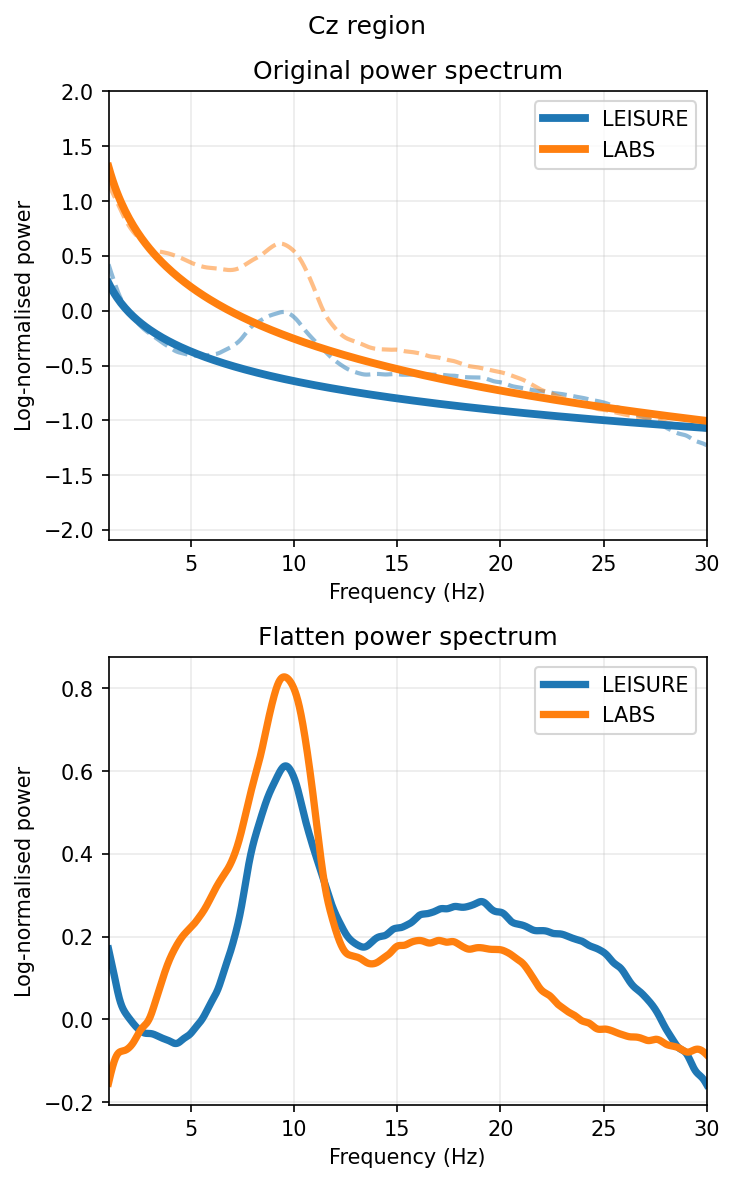

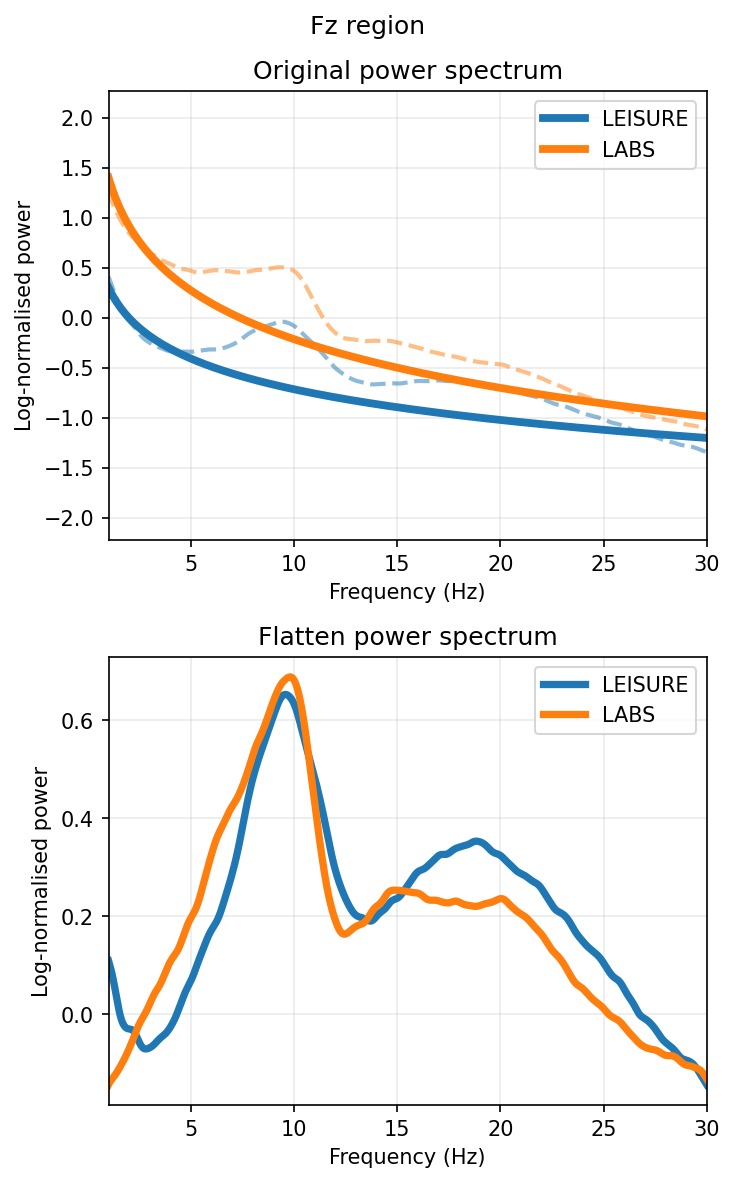

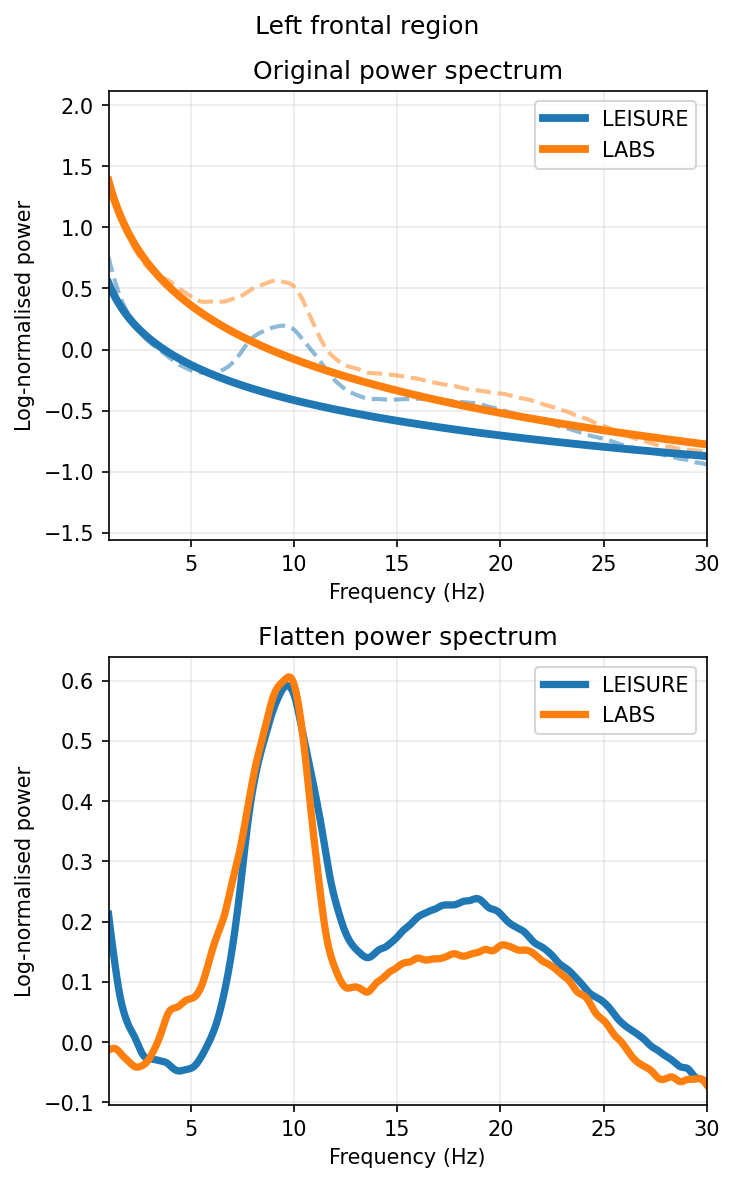

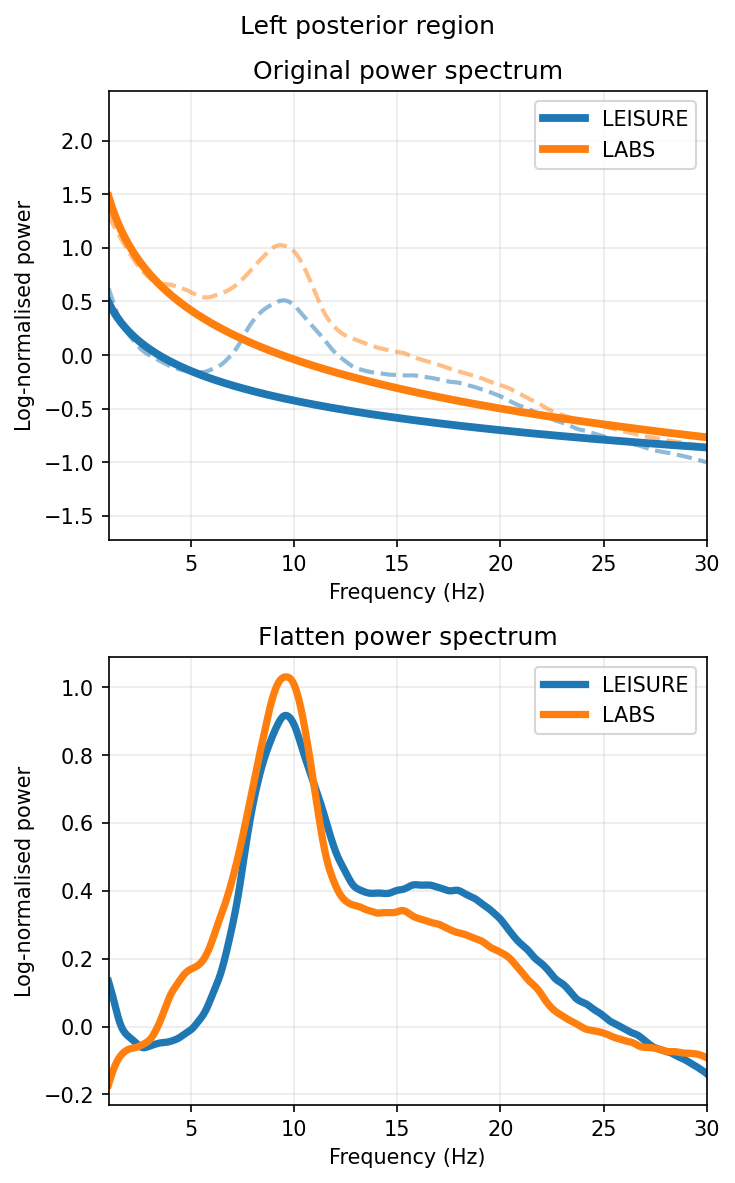

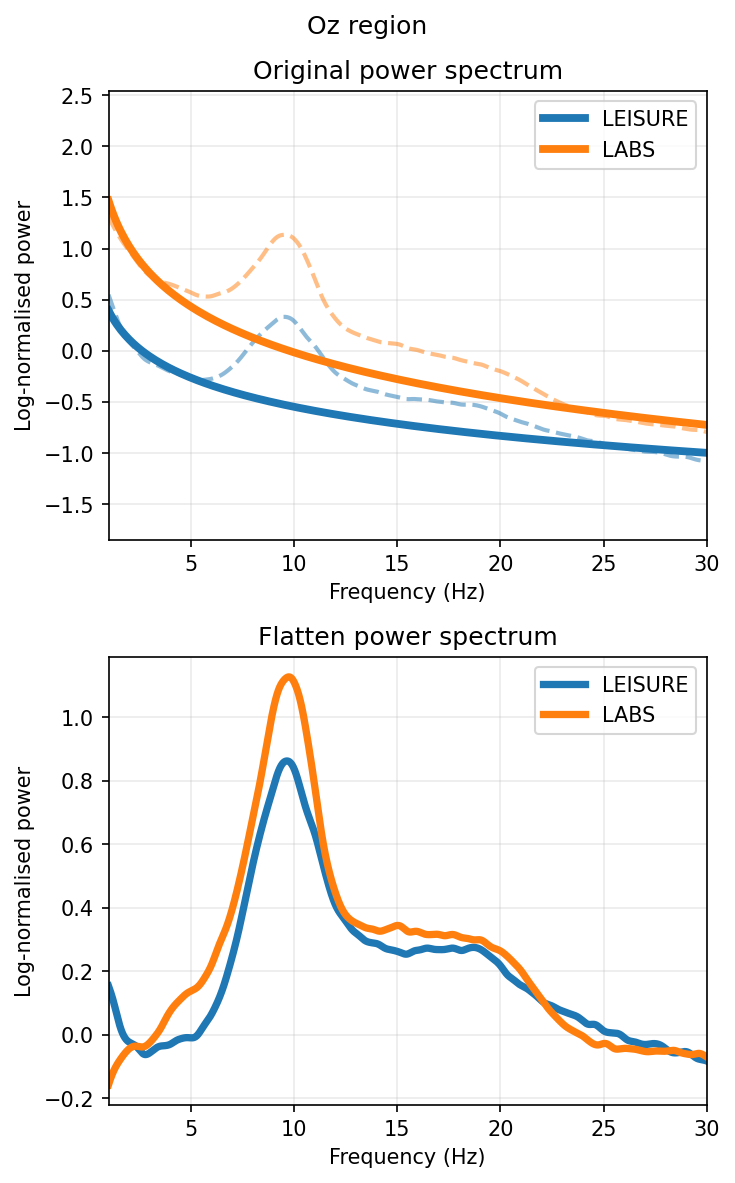

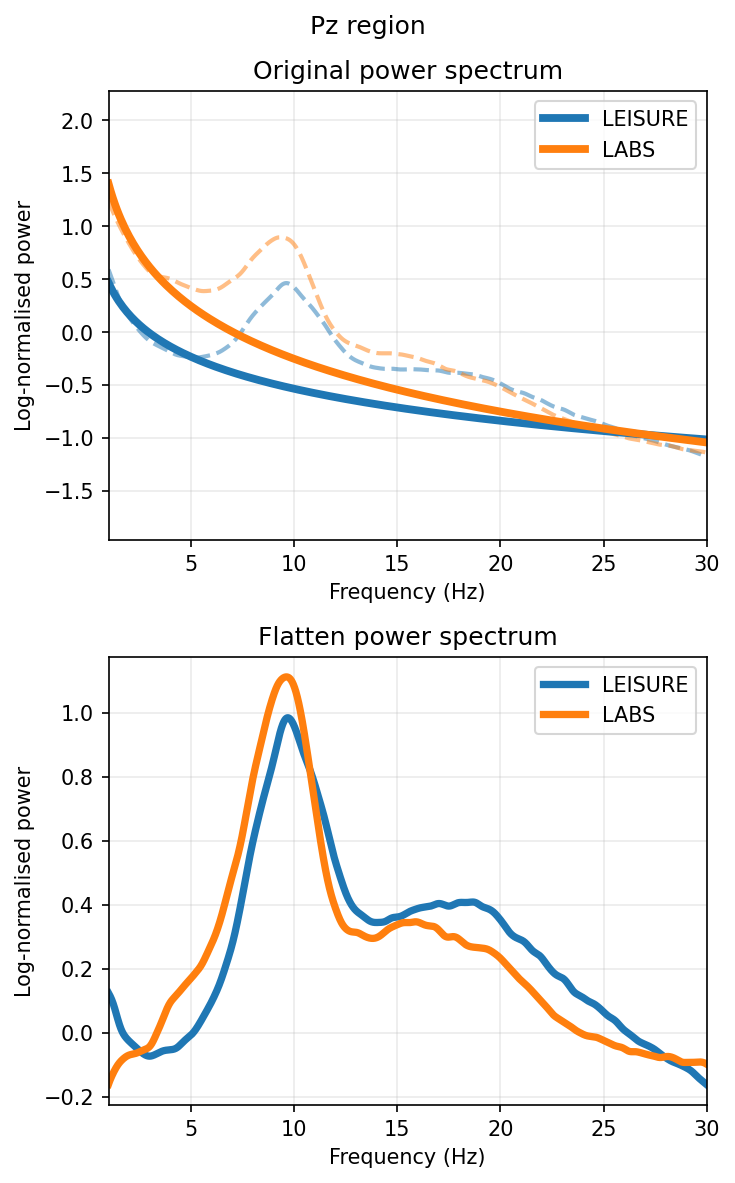

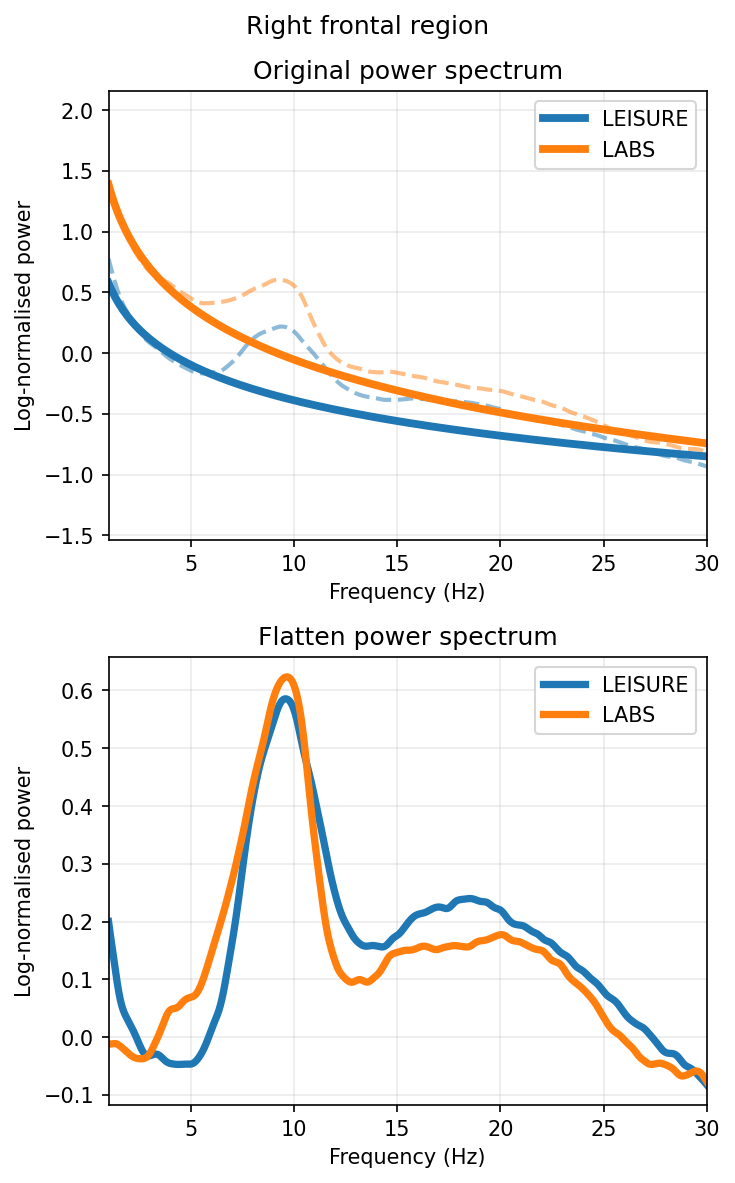

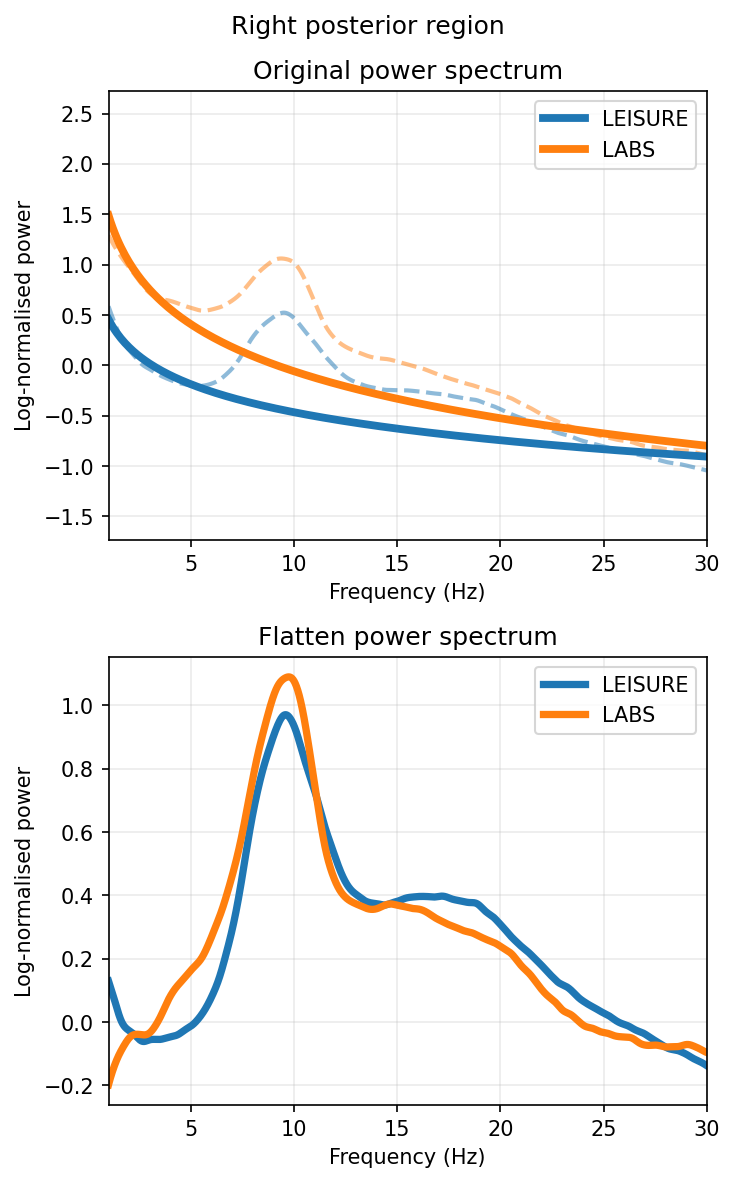

In [183]:
aps_LEISURE = [None]*len(brain_regions)
aps_LABS = [None]*len(brain_regions)
op_LEISURE = [None]*len(brain_regions)
op_LABS = [None]*len(brain_regions)

# Set plot styles
aperiodicfit_kwargs = {'linewidth' : 1.25, 'alpha' : 0}
aperiodicfit_psd_kwargs = {'linewidth' : 2, 'alpha' : 0.5, 'linestyle' : '--'}
periodic_psd_kwargs = {'linewidth' : 3.5, 'alpha' : 1}
acf_kwargs = {'linewidth' : 2, 'alpha' : 0.5, 'linestyle' : '--'}
swarm_kwargs = {'color' : 'gray', 'edgecolor' : 'black', 'size' : 3}

for i, region in enumerate(df_wo_bads['Region'].unique()):
    
    ### PLOT 1.1: original power spectra
    
    # Choose only original PSDs and only the region of interest
    df_psds = df_psd_wo_bads[df_psd_wo_bads['Type']=='powerspectra']
    df_psds = df_psds[df_psds['Region']==region]

    # Create regional original PSD files for both groups
    df_psds_LEISURE = df_psds[df_psds['Group']=='LEISURE'].drop(columns=['Group', 'Type', 'Region'])
    df_psds_LABS = df_psds[df_psds['Group']=='LABS'].drop(columns=['Group', 'Type', 'Region'])

    # Grand average PSDs for both groups
    freqs = df_psds_LEISURE.columns.to_numpy()
    psd_mean_LEISURE = df_psds_LEISURE.mean(axis=0)
    psd_mean_LABS = df_psds_LABS.mean(axis=0)

    # Take only the region of interest for the aperiodic parameters in the df
    df_aps = df_wo_bads[['Offset','Exponent','Group']][df_wo_bads['Region']==region]

    # Convert the offset and exponent for both groups to 2D arrays
    aps_LEISURE[i] = df_aps[df_aps['Group']=='LEISURE'].drop(columns='Group').values
    aps_LABS[i] = df_aps[df_aps['Group']=='LABS'].drop(columns='Group').values

    # Grand average the offset and exponent for both groups for the current region
    aps_LEISURE_mean = aps_LEISURE[i].mean(axis=0)
    aps_LABS_mean = aps_LABS[i].mean(axis=0)

    # Plot aperiodic model fit in log-log scale and aperiodic parameters
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 8), dpi=150)
    plot_spectrum(freqs, psd_mean_LEISURE, ax=axs[0],
                  plot_style=None, **aperiodicfit_psd_kwargs)
    plot_spectrum(freqs, psd_mean_LABS, ax=axs[0],
                  plot_style=None, **aperiodicfit_psd_kwargs)
    plot_aperiodic_fits([aps_LEISURE[i], aps_LABS[i]], log_freqs=False,
                        ax=axs[0], freq_range=freq_range, plot_style=None,
                        labels=exp_condition, **aperiodicfit_kwargs)
    axs[0].grid(linewidth=0.2)
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_ylabel('Log-normalised power')
    if plot_titles==True: (axs[0].set_title('Original power spectrum'))
    axs[0].legend()

    ### PLOT 1.2: flatten power spectra

    # Choose only flatten PSDs and only the region of interest
    df_flatpsds = df_psd_wo_bads[df_psd_wo_bads['Type']=='flatpowerspectra']
    df_flatpsds = df_flatpsds[df_flatpsds['Region']==region]

    # Create regional original PSD files for both groups
    df_flatpsds_LEISURE = df_flatpsds[df_flatpsds['Group']=='LEISURE'].drop(columns=['Group', 'Type', 'Region'])
    df_flatpsds_LABS = df_flatpsds[df_flatpsds['Group']=='LABS'].drop(columns=['Group', 'Type', 'Region'])

    # Grand average PSDs for both groups
    freqs = df_flatpsds_LEISURE.columns.to_numpy()
    flatpsd_mean_LEISURE = df_flatpsds_LEISURE.mean(axis=0)
    flatpsd_mean_LABS = df_flatpsds_LABS.mean(axis=0)

    # # Alpha center frequency average regionally
    # df_acf_reg = df_wo_bads[df_wo_bads['Region']==region]
    # acf_mean_LEISURE = df_acf_reg[df_acf_reg['Group']=='LEISURE']['Alpha CF'].mean(axis=0)
    # acf_mean_LABS = df_acf_reg[df_acf_reg['Group']=='LABS']['Alpha CF'].mean(axis=0)

    df_abw_reg = df_wo_bads[df_wo_bads['Region']==region]
    abw_LEISURE_strs = df_abw_reg[df_abw_reg['Group']=='LEISURE']['Alpha BW']
    abw_LABS_strs = df_abw_reg[df_abw_reg['Group']=='LABS']['Alpha BW']

    abw_LEISURE_lists = [None]*len(abw_LEISURE_strs)
    abw_LABS_lists = [None]*len(abw_LABS_strs)
    for i, item in enumerate(abw_LEISURE_strs):
        abw_LEISURE_lists[i] = ast.literal_eval(item)
    for i, item in enumerate(abw_LABS_strs):
        abw_LABS_lists[i] = ast.literal_eval(item)
    abw_LEISURE = np.array(abw_LEISURE_lists)
    abw_LABS = np.array(abw_LABS_lists)

    abw_mean_LEISURE = abw_LEISURE.mean(axis=0)
    abw_mean_LABS = abw_LABS.mean(axis=0)

    plot_spectrum(freqs, flatpsd_mean_LEISURE, ax=axs[1],
                  plot_style=None, **periodic_psd_kwargs)
    plot_spectrum(freqs, flatpsd_mean_LABS, ax=axs[1],
                  plot_style=None, **periodic_psd_kwargs)
    #axs[1].vlines(x=[], ymin=0, ymax=pw/(pw*1.1), **hvline_kwargs)
    #axs[1].fill_between(x=np.array(freqs, dtype=float)[freqs_idx_bw], y1=flatpsd_mean_LEISURE[freqs_idx_bw])
    freqs = np.array(freqs, dtype=float)
    current_ylim = axs[1].get_ylim()

    #axs[1].fill_between(freqs, flatpsd_mean_LEISURE, current_ylim[0], alpha=0.1)
    #axs[1].fill_between(freqs, flatpsd_mean_LABS, current_ylim[0], alpha=0.075)

    #axs[1].fill_between(freqs, flatpsd_mean_LEISURE, current_ylim[0], where=(freqs>abw_mean_LEISURE[0])&(freqs<=abw_mean_LEISURE[1]), alpha=0.5)
    #axs[1].fill_between(freqs, flatpsd_mean_LABS, current_ylim[0], where=(freqs>abw_mean_LABS[0])&(freqs<=abw_mean_LABS[1]), alpha=0.2)

    # axs[1].plot(acf_mean_LEISURE, max(flatpsd_mean_LEISURE), color='red', marker='*')
    # axs[1].plot(acf_mean_LABS, max(flatpsd_mean_LABS), color='red', marker='*')
    axs[1].set_xlim(freq_range)
    axs[1].set_ylim(current_ylim)
    axs[1].grid(linewidth=0.2)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Log-normalised power')
    if plot_titles==True: (axs[1].set_title('Flatten power spectrum'))
    axs[1].legend(['LEISURE', 'LABS'])
    plt.suptitle('{} region'.format(region))
    plt.tight_layout()
    if savefig == True:
        plt.savefig(fname='{}/{}_aperiodic_alpha_plot.png'.format(savefinal_folder,
                                                                  region), dpi=300)
    plt.show()
    

In [ ]:
aps_LEISURE = [None]*len(brain_regions)
aps_LABS = [None]*len(brain_regions)
op_LEISURE = [None]*len(brain_regions)
op_LABS = [None]*len(brain_regions)

# Set plot styles
aperiodicfit_kwargs = {'linewidth' : 1.25, 'alpha' : 0}
aperiodicfit_psd_kwargs = {'linewidth' : 2, 'alpha' : 0.5, 'linestyle' : '--'}
periodic_psd_kwargs = {'linewidth' : 3.5, 'alpha' : 1}
acf_kwargs = {'linewidth' : 2, 'alpha' : 0.5, 'linestyle' : '--'}
swarm_kwargs = {'color' : 'gray', 'edgecolor' : 'black', 'size' : 3}

for i, region in enumerate(df_wo_bads['Region'].unique()):
    
    ### PLOT 1.1: original power spectra
    
    # Choose only original PSDs and only the region of interest
    df_psds = df_psd_wo_bads[df_psd_wo_bads['Type']=='powerspectra']
    df_psds = df_psds[df_psds['Region']==region]

    # Create regional original PSD files for both groups
    df_psds_LEISURE = df_psds[df_psds['Group']=='LEISURE'].drop(columns=['Group', 'Type', 'Region'])
    df_psds_LABS = df_psds[df_psds['Group']=='LABS'].drop(columns=['Group', 'Type', 'Region'])

    # Grand average PSDs for both groups
    freqs = df_psds_LEISURE.columns.to_numpy()
    psd_mean_LEISURE = df_psds_LEISURE.mean(axis=0)
    psd_mean_LABS = df_psds_LABS.mean(axis=0)

    # Take only the region of interest for the aperiodic parameters in the df
    df_aps = df_wo_bads[['Offset','Exponent','Group']][df_wo_bads['Region']==region]

    # Convert the offset and exponent for both groups to 2D arrays
    aps_LEISURE[i] = df_aps[df_aps['Group']=='LEISURE'].drop(columns='Group').values
    aps_LABS[i] = df_aps[df_aps['Group']=='LABS'].drop(columns='Group').values

    # Grand average the offset and exponent for both groups for the current region
    aps_LEISURE_mean = aps_LEISURE[i].mean(axis=0)
    aps_LABS_mean = aps_LABS[i].mean(axis=0)

    # Plot aperiodic model fit in log-log scale and aperiodic parameters
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 8), dpi=150)
    plot_spectrum(freqs, psd_mean_LEISURE, ax=axs[0],
                  plot_style=None, **aperiodicfit_psd_kwargs)
    plot_spectrum(freqs, psd_mean_LABS, ax=axs[0],
                  plot_style=None, **aperiodicfit_psd_kwargs)
    plot_aperiodic_fits([aps_LEISURE[i], aps_LABS[i]], log_freqs=False,
                        ax=axs[0], freq_range=freq_range, plot_style=None,
                        labels=exp_condition, **aperiodicfit_kwargs)
    axs[0].grid(linewidth=0.2)
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_ylabel('Log-normalised power')
    if plot_titles==True: (axs[0].set_title('Original power spectrum'))
    axs[0].legend()

    ### PLOT 1.2: flatten power spectra

    # Choose only flatten PSDs and only the region of interest
    df_flatpsds = df_psd_wo_bads[df_psd_wo_bads['Type']=='flatpowerspectra']
    df_flatpsds = df_flatpsds[df_flatpsds['Region']==region]

    # Create regional original PSD files for both groups
    df_flatpsds_LEISURE = df_flatpsds[df_flatpsds['Group']=='LEISURE'].drop(columns=['Group', 'Type', 'Region'])
    df_flatpsds_LABS = df_flatpsds[df_flatpsds['Group']=='LABS'].drop(columns=['Group', 'Type', 'Region'])

    # Grand average PSDs for both groups
    freqs = df_flatpsds_LEISURE.columns.to_numpy()
    flatpsd_mean_LEISURE = df_flatpsds_LEISURE.mean(axis=0)
    flatpsd_mean_LABS = df_flatpsds_LABS.mean(axis=0)

    # # Alpha center frequency average regionally
    # df_acf_reg = df_wo_bads[df_wo_bads['Region']==region]
    # acf_mean_LEISURE = df_acf_reg[df_acf_reg['Group']=='LEISURE']['Alpha CF'].mean(axis=0)
    # acf_mean_LABS = df_acf_reg[df_acf_reg['Group']=='LABS']['Alpha CF'].mean(axis=0)

    df_abw_reg = df_wo_bads[df_wo_bads['Region']==region]
    abw_LEISURE_strs = df_abw_reg[df_abw_reg['Group']=='LEISURE']['Alpha BW']
    abw_LABS_strs = df_abw_reg[df_abw_reg['Group']=='LABS']['Alpha BW']

    abw_LEISURE_lists = [None]*len(abw_LEISURE_strs)
    abw_LABS_lists = [None]*len(abw_LABS_strs)
    for i, item in enumerate(abw_LEISURE_strs):
        abw_LEISURE_lists[i] = ast.literal_eval(item)
    for i, item in enumerate(abw_LABS_strs):
        abw_LABS_lists[i] = ast.literal_eval(item)
    abw_LEISURE = np.array(abw_LEISURE_lists)
    abw_LABS = np.array(abw_LABS_lists)

    abw_mean_LEISURE = abw_LEISURE.mean(axis=0)
    abw_mean_LABS = abw_LABS.mean(axis=0)

    plot_spectrum(freqs, flatpsd_mean_LEISURE, ax=axs[1],
                  plot_style=None, **periodic_psd_kwargs)
    plot_spectrum(freqs, flatpsd_mean_LABS, ax=axs[1],
                  plot_style=None, **periodic_psd_kwargs)

    axs[1].set_xlim(freq_range)
    axs[1].set_ylim(current_ylim)
    axs[1].grid(linewidth=0.2)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Log-normalised power')
    if plot_titles==True: (axs[1].set_title('Flatten power spectrum'))
    axs[1].legend(['LEISURE', 'LABS'])
    plt.suptitle('{} region'.format(region))
    plt.tight_layout()
    if savefig == True:
        plt.savefig(fname='{}/{}_aperiodic_alpha_plot.png'.format(savefinal_folder,
                                                                  region), dpi=300)
    plt.show()

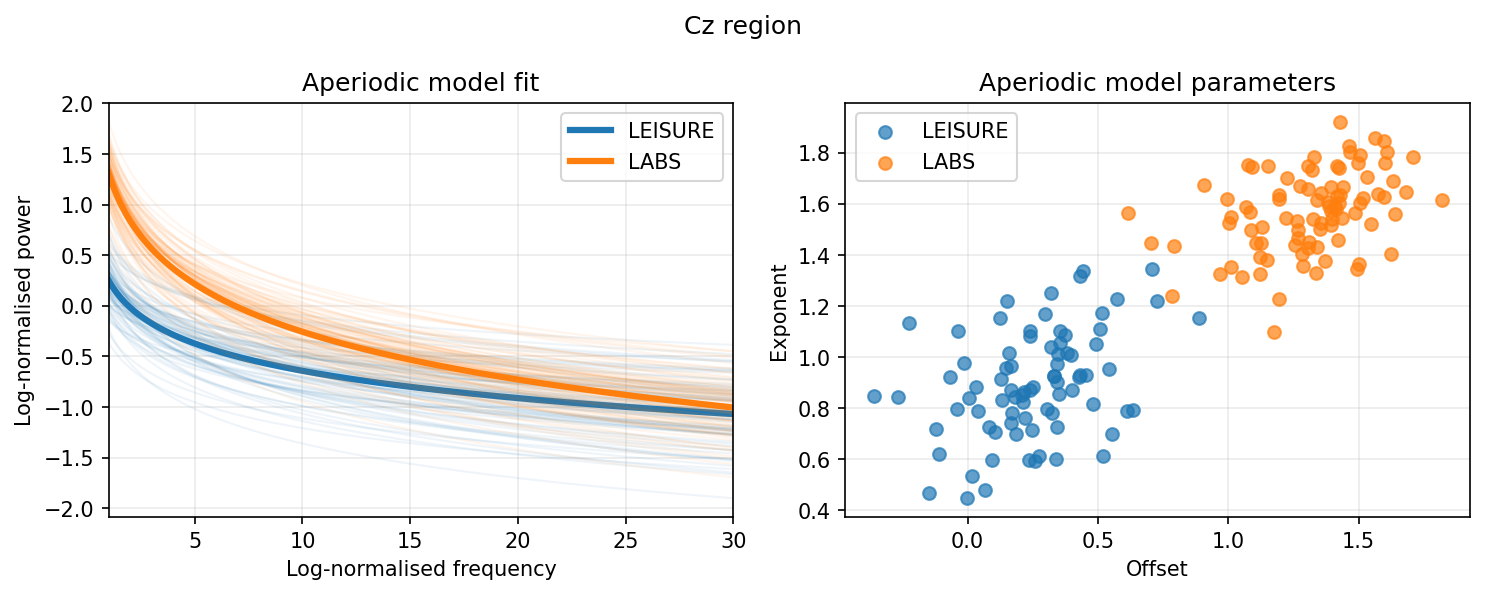

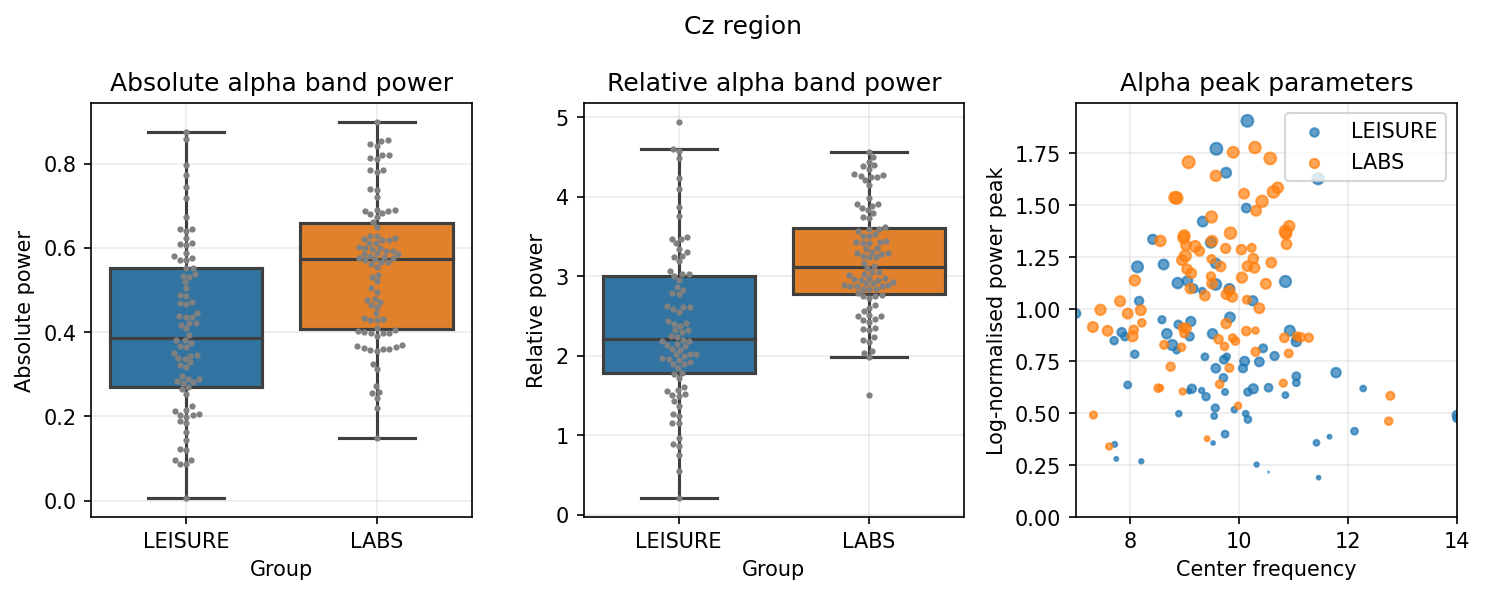

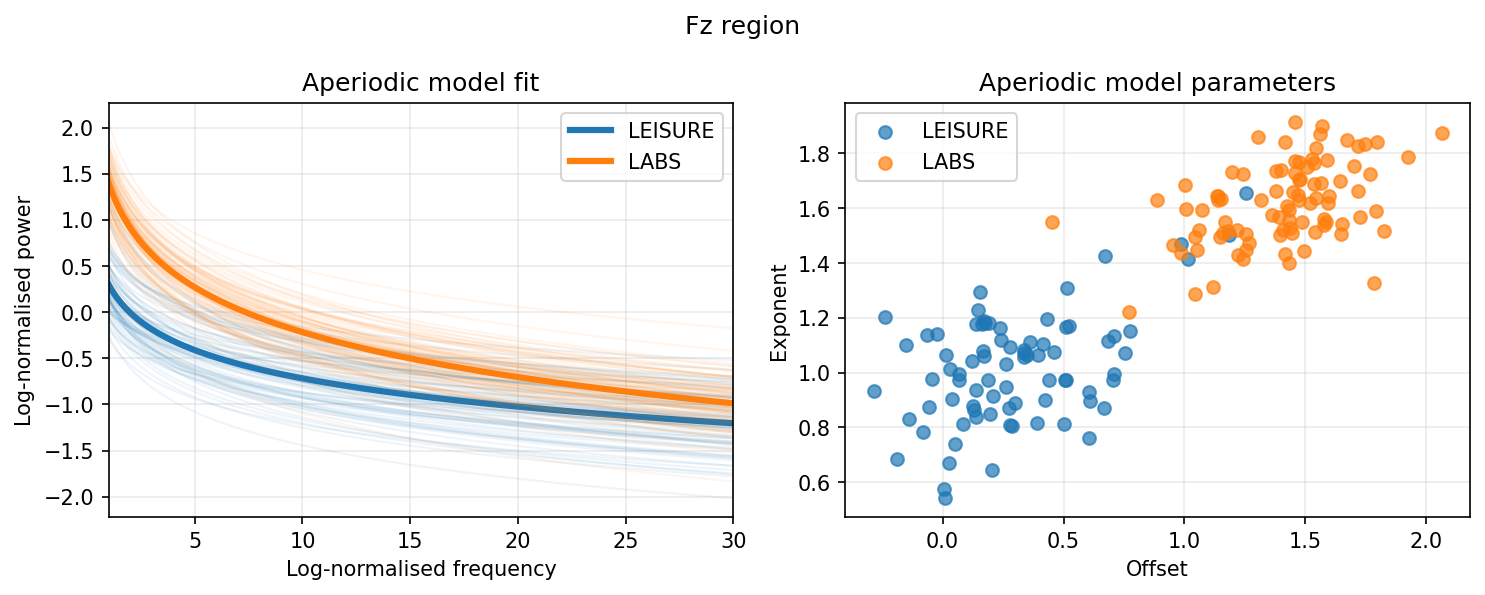

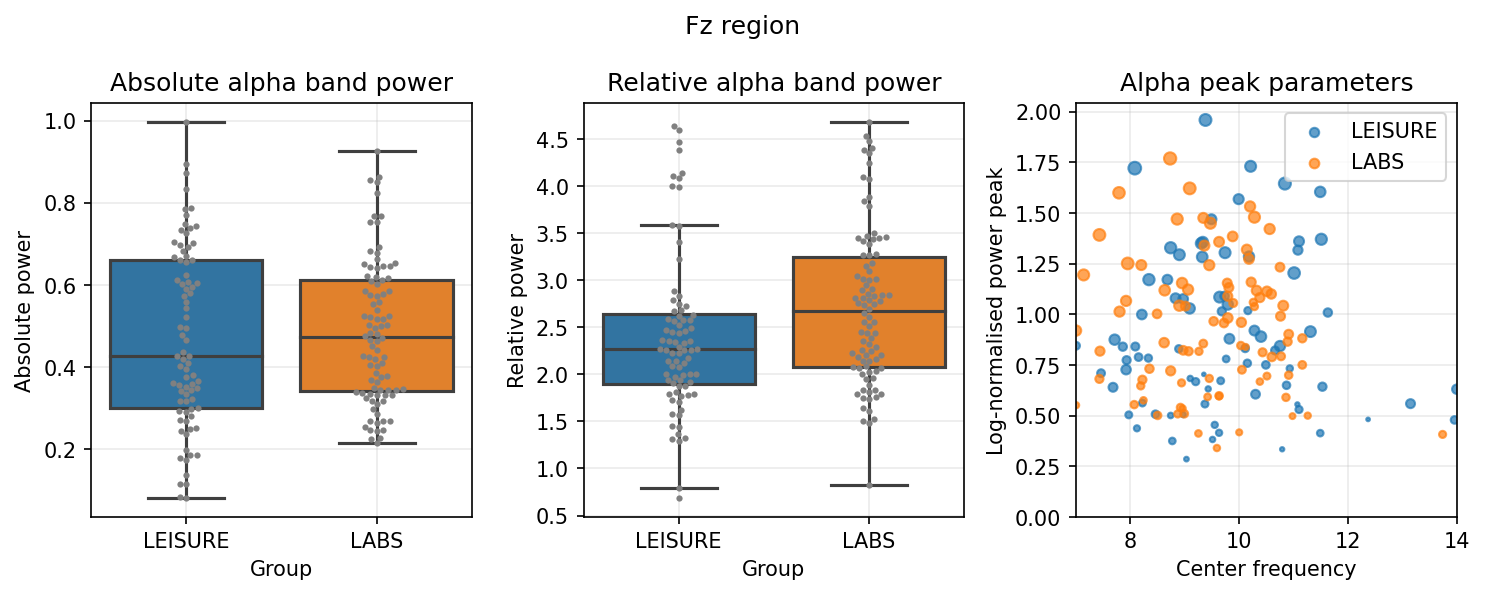

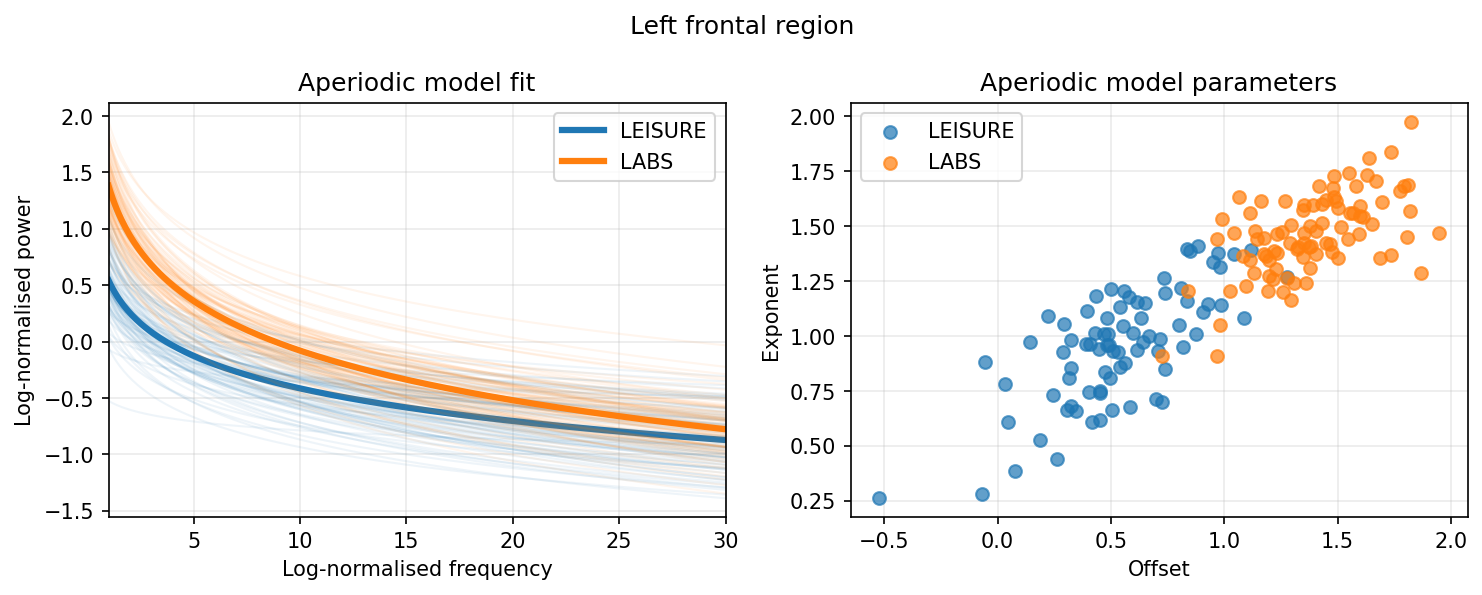

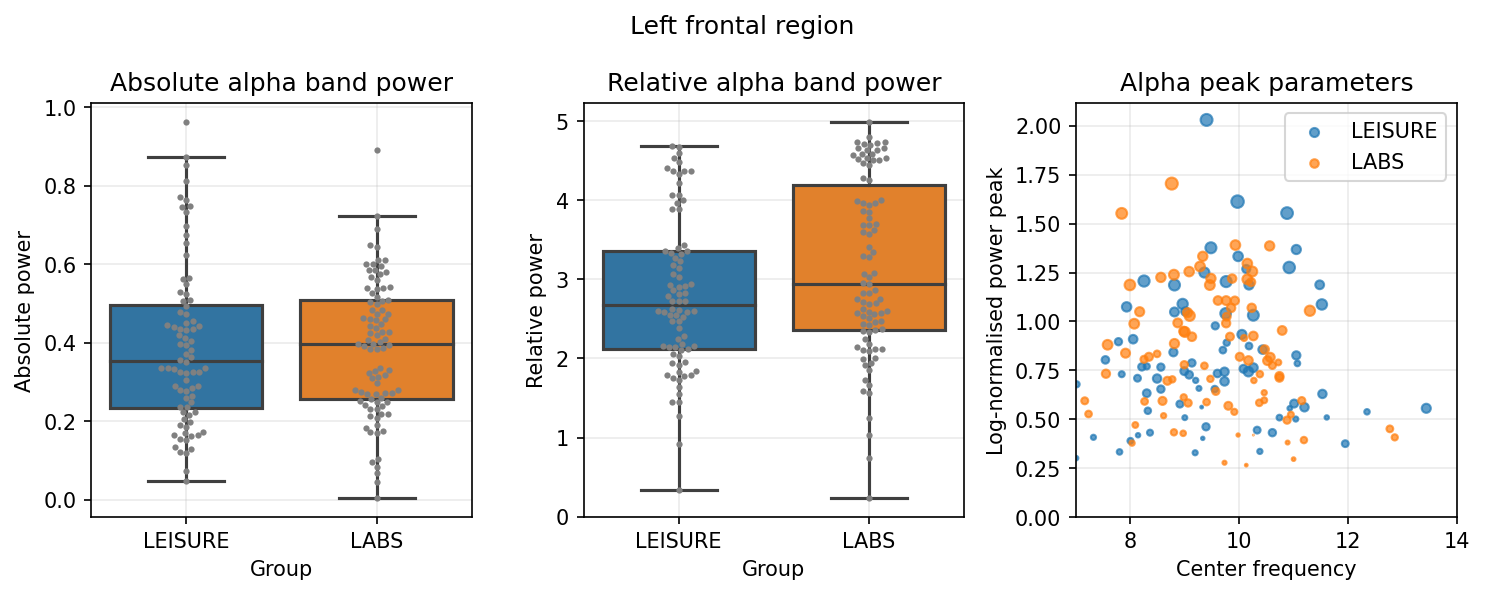

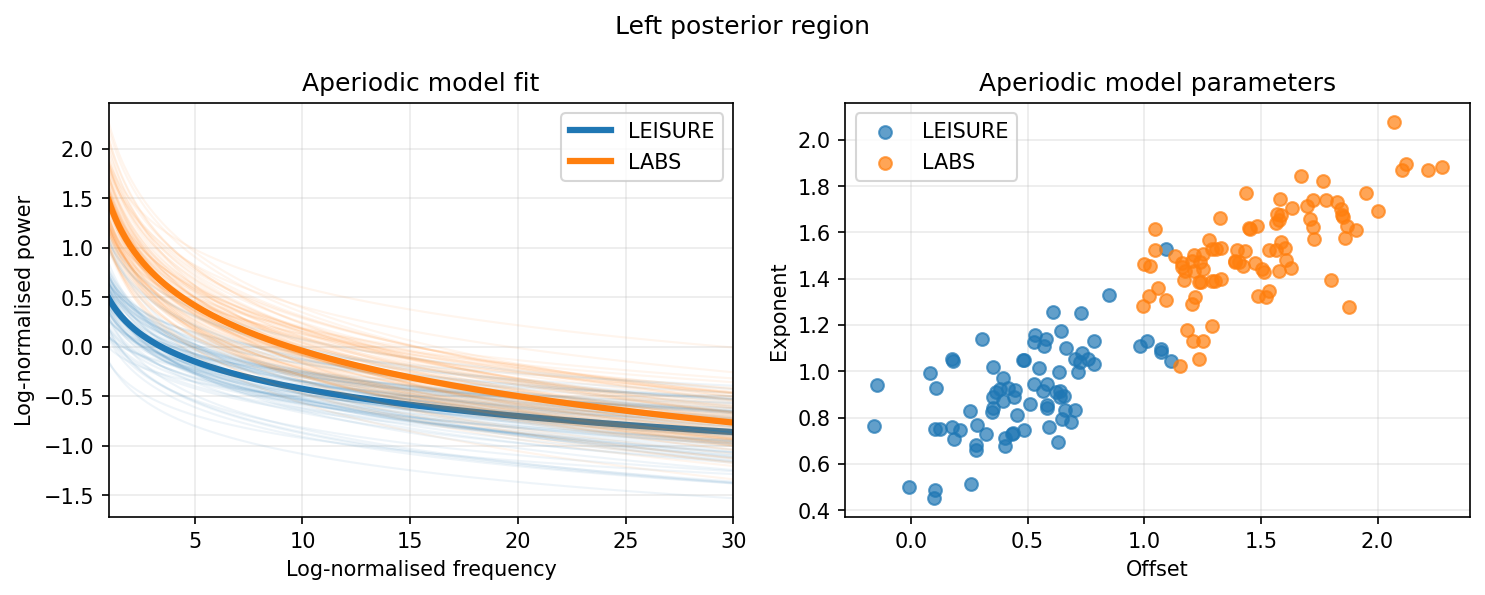

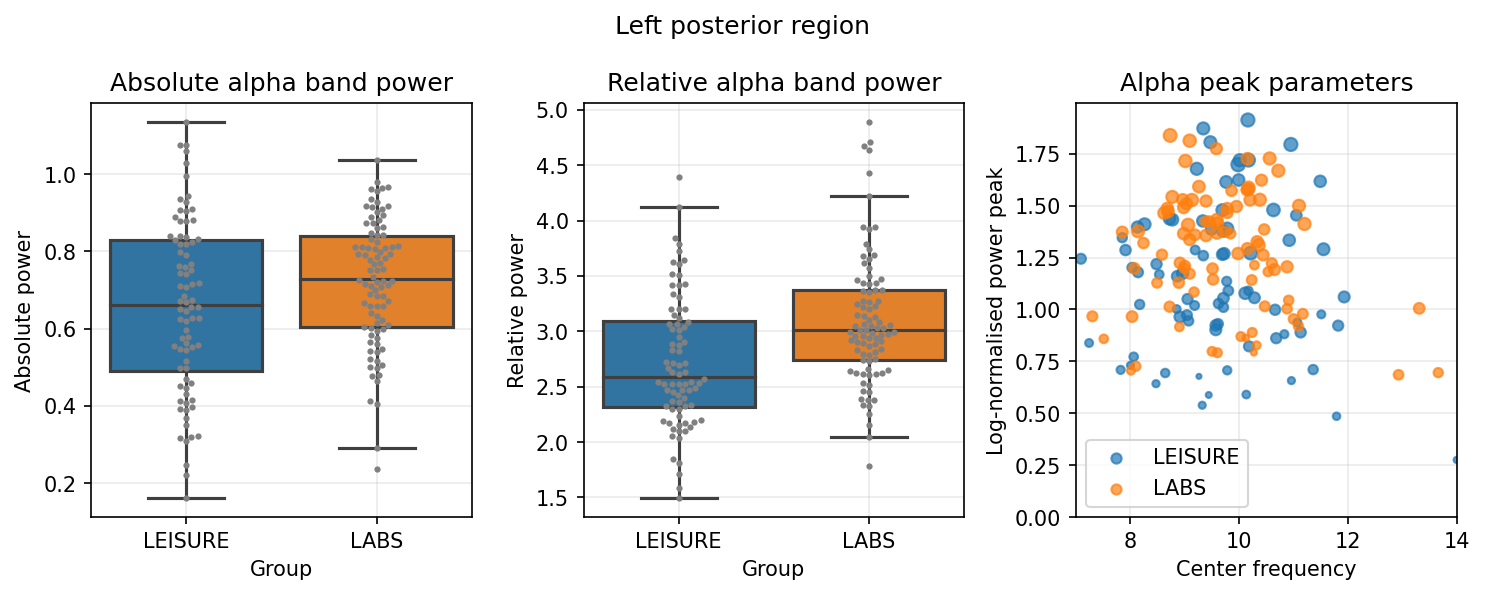

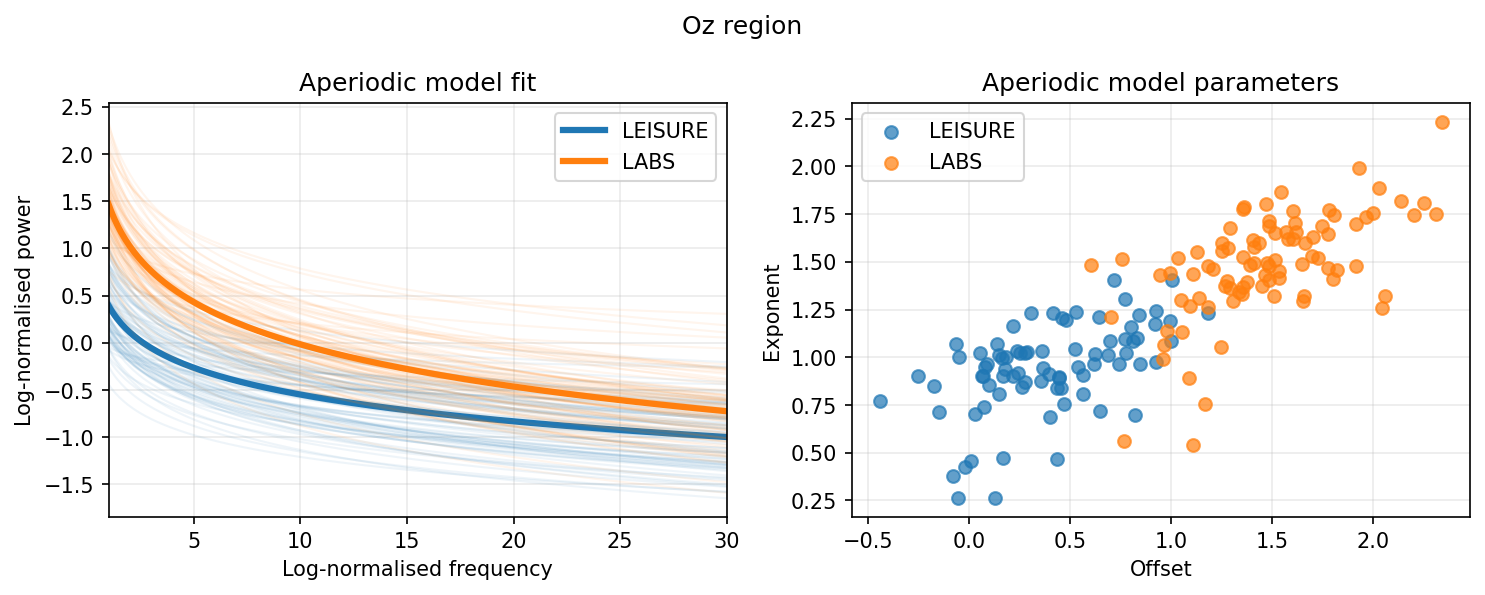

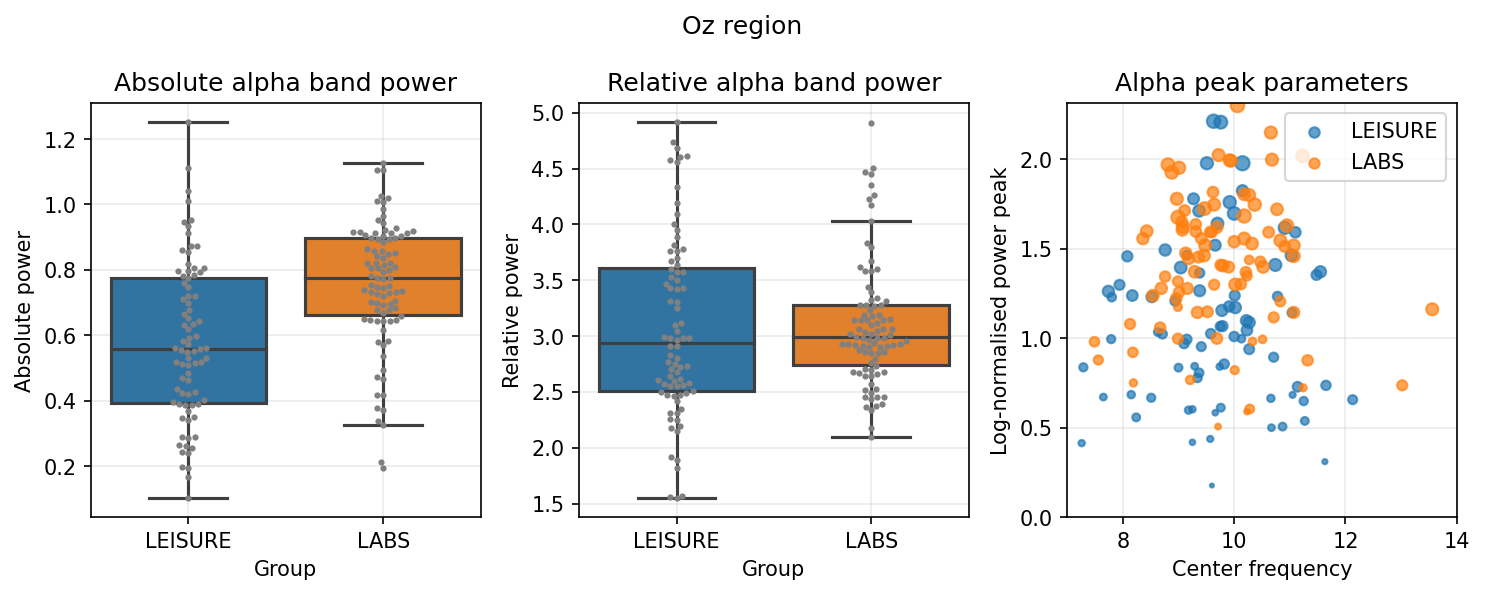

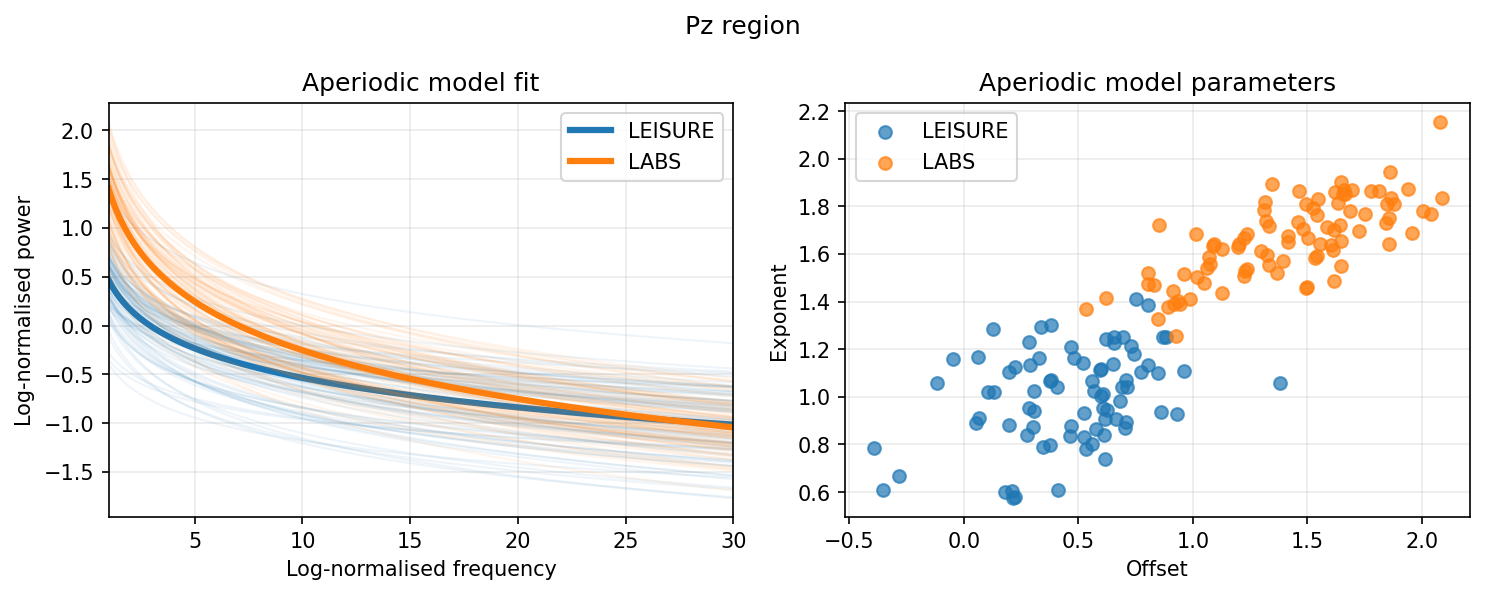

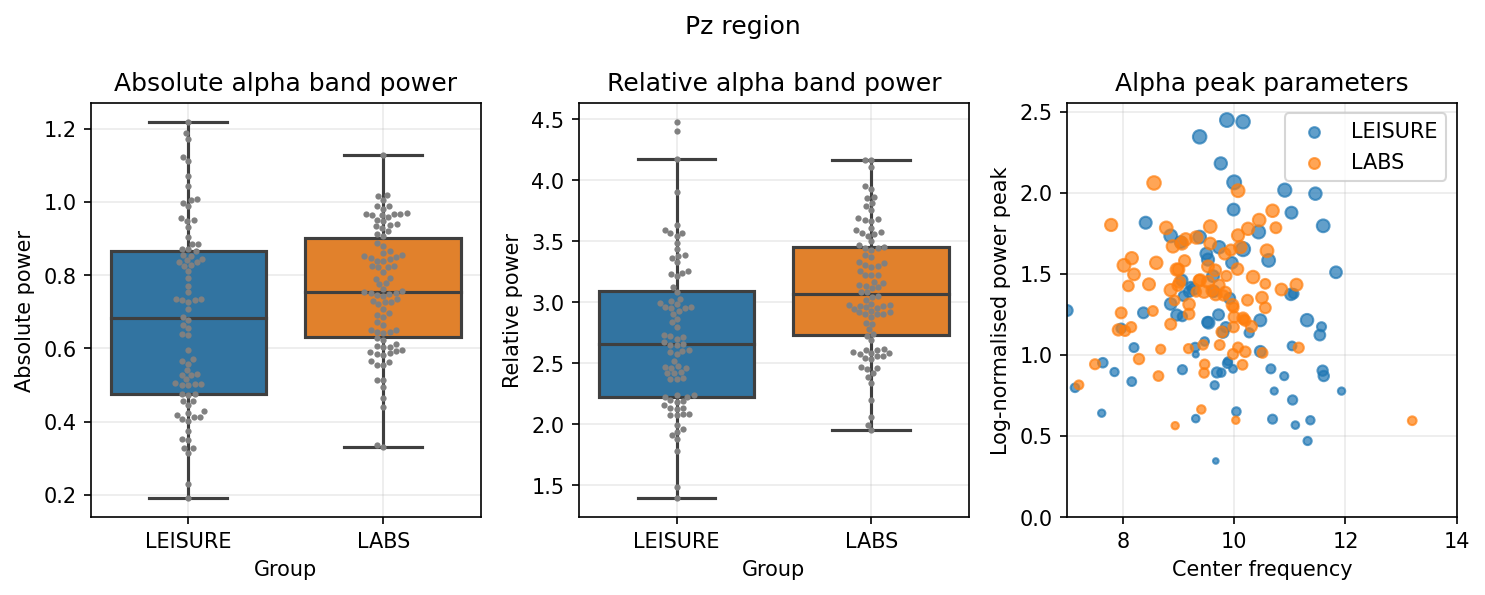

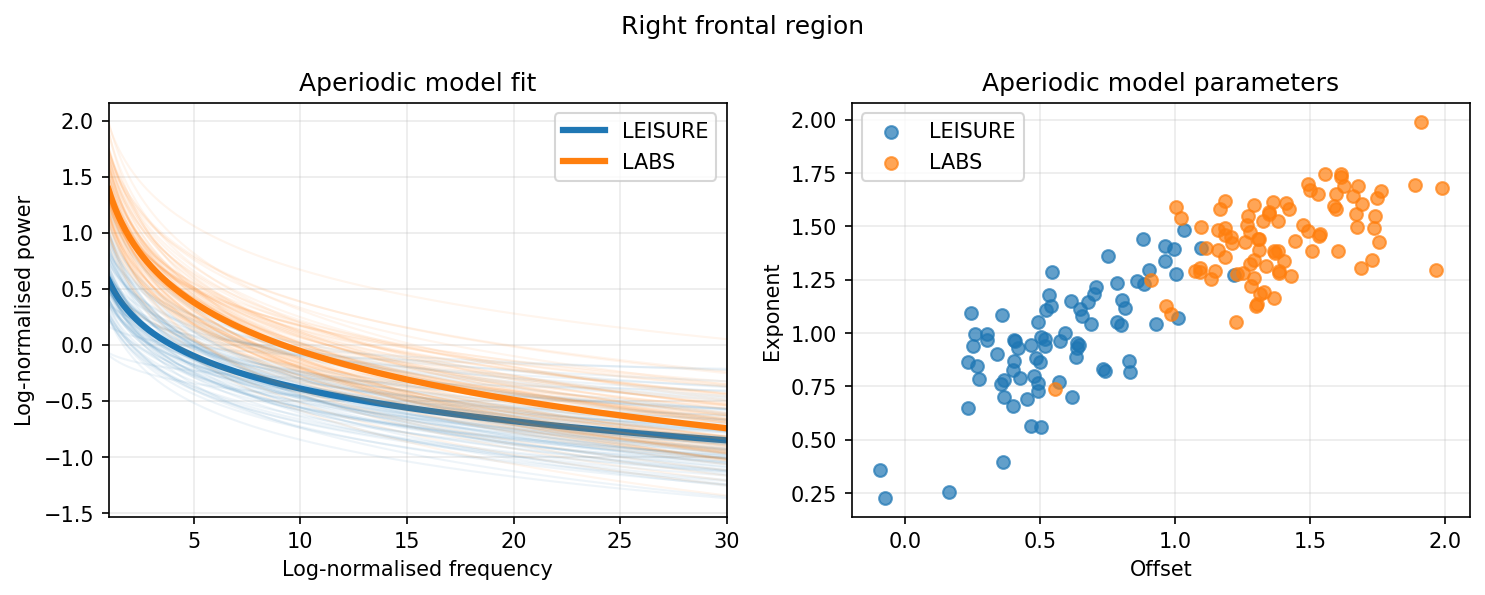

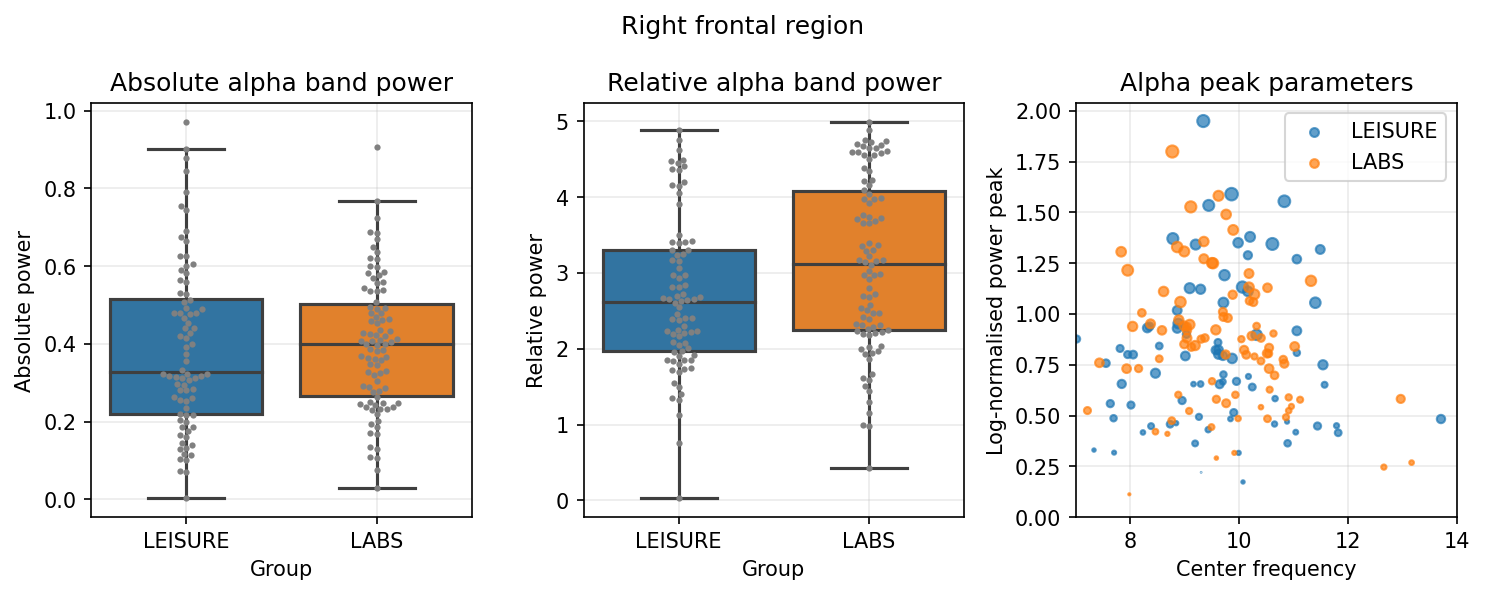

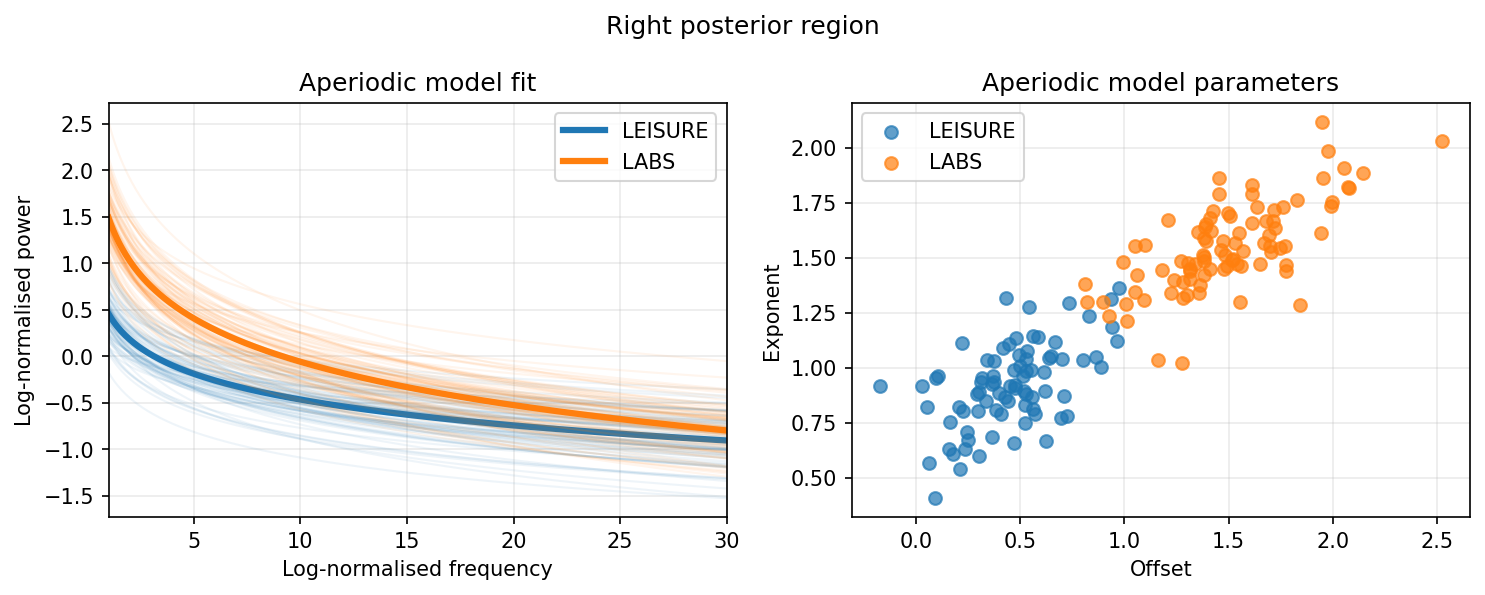

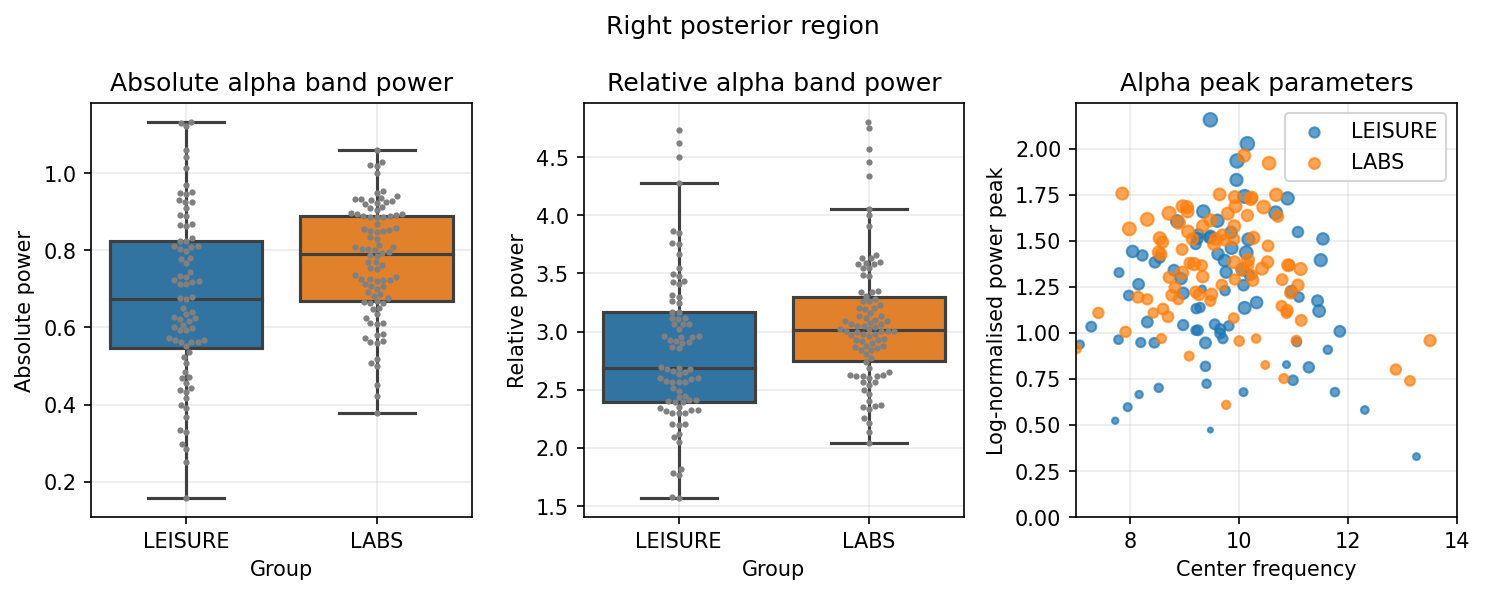

In [184]:
aps_LEISURE = [None]*len(brain_regions)
aps_LABS = [None]*len(brain_regions)
op_LEISURE = [None]*len(brain_regions)
op_LABS = [None]*len(brain_regions)

# Set plot styles
aperiodicfit_kwargs = {'linewidth' : 1, 'alpha' : 0.075}
aperiodicparams_kwargs = {'marker' : '.'}
swarm_kwargs = {'color' : 'gray', 'edgecolor' : 'black', 'size' : 3}

for i, region in enumerate(df_wo_bads['Region'].unique()):
    
    ### PLOT 1: aperiodic activity

    # Take only the region of interest for the aperiodic parameters in the df
    df_aps = df_wo_bads[['Offset','Exponent','Group']][df_wo_bads['Region']==region]

    # Convert the offset and exponent for both groups to 2D arrays
    aps_LEISURE[i] = df_aps[df_aps['Group']=='LEISURE'].drop(columns='Group').values
    aps_LABS[i] = df_aps[df_aps['Group']=='LABS'].drop(columns='Group').values

    # Plot aperiodic model fit in log-log scale and aperiodic parameters
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=150)
    plot_aperiodic_fits([aps_LEISURE[i], aps_LABS[i]], log_freqs=False,
                        ax=axs[0], freq_range=freq_range, plot_style=None,
                        labels=exp_condition, **aperiodicfit_kwargs)
    axs[0].grid(linewidth=0.2)
    axs[0].set_xlabel('Log-normalised frequency')
    axs[0].set_ylabel('Log-normalised power')
    if plot_titles==True: (axs[0].set_title('Aperiodic model fit'))
    axs[0].legend()
    plot_aperiodic_params([aps_LEISURE[i], aps_LABS[i]], ax=axs[1],
                          plot_style=None, labels=exp_condition,
                          **aperiodicparams_kwargs)
    axs[1].grid(linewidth=0.2)
    axs[1].set_xlabel('Offset')
    axs[1].set_ylabel('Exponent')
    if plot_titles==True: (axs[1].set_title('Aperiodic model parameters'))
    axs[1].legend()
    plt.suptitle('{} region'.format(region))
    plt.tight_layout()
    if savefig == True:
        plt.savefig(fname='{}/{}_aperiodic_plot.png'.format(savefinal_folder,
                                                            region), dpi=300)
    plt.show()

    ### PLOT 2: alpha activity

    # Take only the region of interest for the oscillatory peak in the df
    df_op = df_wo_bads[['Alpha CF', 'Alpha PW', 'Alpha absolute power',
                        'Group']][df_wo_bads['Region']==region]

    # Convert the alpha CF, PW, absolute and relative powers for both groups to 2D arrays
    op_LEISURE[i] = df_op[df_op['Group']=='LEISURE'].drop(columns='Group').values
    op_LABS[i] = df_op[df_op['Group']=='LABS'].drop(columns='Group').values

    # Take only the region of interest for the power values in the df
    df_powers = df_wo_bads[['Alpha absolute power', 'Alpha relative power',
                            'Group']][df_wo_bads['Region']==region]

    # Plot alpha absolute and relative powers and alpha peak parameters
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), dpi=150)
    sns.boxplot(ax=axs[0], data=df_powers[['Alpha absolute power', 'Group']],
                x='Group', y='Alpha absolute power', showfliers = False)
    sns.swarmplot(ax=axs[0], data=df_powers[['Alpha absolute power', 'Group']],
                  x='Group', y='Alpha absolute power', **swarm_kwargs)
    axs[0].grid(linewidth=0.2)
    axs[0].set_xlabel('Group')
    axs[0].set_ylabel('Absolute power')
    if plot_titles==True: (axs[0].set_title('Absolute alpha band power'))
    sns.boxplot(ax=axs[1], data=df_powers[['Alpha relative power', 'Group']],
                x='Group', y='Alpha relative power', showfliers = False)
    sns.swarmplot(ax=axs[1], data=df_powers[['Alpha relative power', 'Group']],
                  x='Group', y='Alpha relative power', **swarm_kwargs)
    axs[1].grid(linewidth=0.2)
    axs[1].set_xlabel('Group')
    axs[1].set_ylabel('Relative power')
    if plot_titles==True: (axs[1].set_title('Relative alpha band power'))
    plot_peak_params([op_LEISURE[i], op_LABS[i]],
                     ax=axs[2], freq_range=[7, 14], plot_style=None,
                     labels=exp_condition, **aperiodicparams_kwargs)
    axs[2].grid(linewidth=0.2)
    axs[2].set_xlabel('Center frequency')
    axs[2].set_ylabel('Log-normalised power peak')
    if plot_titles==True: (axs[2].set_title('Alpha peak parameters'))
    axs[2].legend()
    plt.suptitle('{} region'.format(region))
    plt.tight_layout()
    if savefig == True:
       plt.savefig(fname='{}/{}_alpha_plot.png'.format(savefinal_folder,
                                                       region), dpi=300)
    plt.show()
    